In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tqdm.notebook import trange

import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as ss

In [ ]:
import time

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import scipy.stats as ss

In [ ]:
from latentPosteriorEstimation.msgmm import MSGMM

In [ ]:
from sklearn.mixture import GaussianMixture

# Synthetic

In [ ]:

from scipy.stats import norm, uniform,dirichlet
from scipy.stats import multivariate_normal as mvn
import scipy.stats as stats

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from random import seed, randint, random
from sklearn import metrics
from matplotlib import pyplot as plt
from types import SimpleNamespace as SN
from sklearn.datasets import make_spd_matrix as spd

class mixture:

    def __init__(self, components, mixing_proportion):
        self.comps = components
        self.mixProp = mixing_proportion
        # self.sigmoid = activations.sigmoid()

    def pdf(self, x):
        return np.sum((p * comp.pdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def cdf(self, x):
        return np.sum((p * comp.cdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def rvs(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            if len(new.shape) == 1:
                new = np.expand_dims(new,1)
            x = np.concatenate((x,new), axis=0)
        #pdb.set_trace()
        return x

    def rvsCompInfo(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        #pdb.set_trace()
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        y = np.empty([0, 1])
        k = 0
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            print(x.shape, new.shape)
            x = np.concatenate((x, new), axis=0)
            y = np.concatenate((y, np.zeros([s, 1]) + k), axis=0)
            k = k + 1
        #pdb.set_trace()
        return x, y

    def component_pdfs(self, x):
        return (comp.pdf(x) for comp in self.comps)

class DataGenerator:

    def __init__(self, dist_p, dist_n, alpha, n_p, n_u, batch_size=1024):
        self.dist_p = dist_p
        self.dist_n = dist_n
        self.alpha = alpha
        self.n_p = n_p
        self.n_u = n_u
        self.n_up = np.cast['int32'](np.floor(n_u * alpha))
        self.n_un = self.n_u - self.n_up
        self.batch_size = batch_size

    @classmethod
    def _shuffle_in_unison(self, a, b):
        p = np.random.permutation(len(a))
        return a[p],b[p]
        
    def data_pos(self, n):
        #pdb.set_trace()
        return np.reshape(self.dist_p.rvs(size=n), newshape=(n, -1))


    def data_neg(self, n):
        return np.reshape(self.dist_n.rvs(size=n), newshape=(n, -1))

    def data_pos_compInfo(self, n):
        #pdb.set_trace()
        x, c = self.dist_p.rvsCompInfo(size=n)
        x = np.reshape(x, newshape=(n, -1))
        return x, c

    def data_neg_compInfo(self, n):
        x, c = self.dist_n.rvsCompInfo(size=n)
        x = np.reshape(x, newshape=(n, -1))
        return x, c

    def data_ul(self, n, alpha):
        n_up = np.cast['int32'](np.floor(n * alpha))
        n_un = n - n_up
        x_up = self.data_pos(n_up)
        x_un = self.data_neg(n_un)
        x = np.concatenate((x_up, x_un), axis=0)
        y = np.zeros([n, 1])
        y[np.arange(x_up.shape[0]), 0] = 1
        return x, y

    def pu_data(self):
        x_p = self.data_pos(self.n_p)
        x_u, y_u = self.data_ul(self.n_u, self.alpha)
        x_pu = np.concatenate((x_p, x_u), axis=0)
        y_pu = np.zeros([x_pu.shape[0], 1])
        y_pu[np.arange(self.n_p), 0] = 1
        y_pn = np.concatenate((np.ones([self.n_p, 1]), y_u), axis=0)
        # y_pn = y_pu
        # y_pn[x_pu.size(0):(self.n_p - 1):-1, 0] = y_u
        return x_pu, y_pu, y_pn
        
    def pn_data(self, n, alpha):
        "return x,y"
        x_p = self.data_pos(int(alpha*n))
        x_n = self.data_neg(int((1-alpha)*n))
        y_p = np.ones((len(x_p), 1))
        y_n = np.zeros((len(x_n), 1))
        x = np.vstack((x_p, x_n))
        y = np.vstack((y_p, y_n))
        x, y = self._shuffle_in_unison(x, y)
        return x, y

    def pn_data_compInfo(self, n, alpha):
        x_p, c_p = self.data_pos_compInfo(int(alpha*n))
        x_n, c_n = self.data_neg_compInfo(int((1-alpha)*n))
        y_p = np.ones((len(x_p), 1))
        y_n = np.zeros((len(x_n), 1))
        x = np.vstack((x_p, x_n))
        y = np.vstack((y_p, y_n))
        c = np.vstack((c_p, c_n))
        return x, y, c
    
    def dens_pos(self, x):
        return self.dist_p.pdf(x)

    def dens_neg(self, x):
        return self.dist_n.pdf(x)

    def dens_mix(self, x, a):
        return a * self.dens_pos(x) + (1 - a) * self.dens_neg(x)

    def pn_posterior(self, x, a):
        return a * self.dens_pos(x) / self.dens_mix(x, a)

    def pu_posterior(self, x):
        c1 = self.n_p / (self.n_u + self.n_p)
        c2 = (self.n_up + self.n_p) / (self.n_u + self.n_p)
        return c1 * self.dens_pos(x) / self.dens_mix(x, c2)

    def pn_posterior_sts(self, x):
        c = (self.n_up + self.n_p) / (self.n_u + self.n_p)
        return self.pn_posterior(x, c)

    def pn_posterior_cc(self, x):
        return self.pn_posterior(x, self.alpha)

    def pn_posterior_balanced(self, x):
        return self.pn_posterior(x, 0.5)


class GaussianDG(DataGenerator):

    def __init__(self, mu, sig, alpha, n_p, n_u, batch_size=1024):
        dist_p = norm(loc=0, scale=1)
        dist_n = norm(loc=mu, scale=sig)
        super(GaussianDG, self).__init__(dist_p=dist_p, dist_n=dist_n, alpha=alpha, n_p=n_p, n_u=n_u, batch_size=batch_size)


class UniformDG(DataGenerator):

    def __init__(self, mu, sig, alpha, n_p, n_u, batch_size=1024):
        dist_p = uniform(loc=0, scale=1)
        dist_n = uniform(loc=mu, scale=sig)
        super(UniformDG, self).__init__(dist_p=dist_p, dist_n=dist_n, alpha=alpha, n_p=n_p, n_u=n_u, batch_size=batch_size)


class NormalMixDG(DataGenerator):

    def __init__(self, mu_pos, sig_pos, p_pos, mu_neg, sig_neg, p_neg, alpha, n_pos, n_ul, batch_size = 1024):
        components_pos = [norm(loc=mu, scale=sig) for (mu, sig) in zip(mu_pos, sig_pos)]
        components_neg = [norm(loc=mu, scale=sig) for (mu, sig) in zip(mu_neg, sig_neg)]
        dist_pos = mixture(components_pos, p_pos)
        dist_neg = mixture(components_neg, p_neg)
        super(NormalMixDG, self).__init__(dist_p=dist_pos, dist_n=dist_neg, alpha=alpha, n_p=n_pos, n_u=n_ul, batch_size=batch_size)


class MVNormalMixDG(DataGenerator):

    def __init__(self, mu_pos, sig_pos, p_pos, mu_neg, sig_neg, p_neg, alpha, n_pos, n_ul, batch_size = 1024):
        self.components_pos = [mvn(mean=mu, cov=sig) for (mu, sig) in zip(mu_pos, sig_pos)]
        self.components_neg = [mvn(mean=mu, cov=sig) for (mu, sig) in zip(mu_neg, sig_neg)]
        dist_pos = mixture(self.components_pos, p_pos)
        dist_neg = mixture(self.components_neg, p_neg)
        super(MVNormalMixDG, self).__init__(dist_p=dist_pos, dist_n=dist_neg, alpha=alpha, n_p=n_pos, n_u=n_ul, batch_size=batch_size)


class NormalMixParameters:

    def __init__(self, dim, max_comps, quiet=False):
        self.dim = dim
        self.max_comps = max_comps
        #self.n_comps_pos = randint(1, max_comps)
        #self.n_comps_neg = randint(1, max_comps)
        self.n_comps_pos = max_comps
        self.n_comps_neg = max_comps
        self.mu_pos = list()
        self.mu_neg = list()
        for i in np.arange(max(self.n_comps_pos, self.n_comps_neg)):
            mu = np.array([16/np.sqrt(self.dim) * random() - 8/np.sqrt(self.dim) for i in np.arange(self.dim)])
            if i < self.n_comps_pos:
                self.mu_pos.append(mu)
            if i < self.n_comps_neg:
                self.mu_neg.append(mu)
        #self.mu_pos = [np.zeros(dim) for j in np.arange(self.n_comps_pos)]
        #self.mu_neg = [np.zeros(dim) for j in np.arange(self.n_comps_neg)]
        self.sig_pos = [np.identity(dim) for j in np.arange(self.n_comps_pos)]
        self.sig_neg = [np.identity(dim) for j in np.arange(self.n_comps_neg)]
        self.p_pos = dirichlet(np.ones(self.n_comps_pos)).rvs([])
        #self.p_neg = dirichlet(np.ones(self.n_comps_neg)).rvs([])
        self.p_neg = self.p_pos
        #self.changeInfo = {'changed': False, 'positive': True, 'mu': True, 'ix':0, 'oldvalue': self.mu_pos[0]}
        self.changeInfo = {'changed': False}
        self.alpha = random()
        self.quiet = quiet

    def computePNDataMetrics(self):
        epsilon = 0.05
        n = 10000
        _, x, y, pos, neg, dg = self.generatePNData(n, n)
        posterior_pos = dg.pn_posterior_balanced(pos)
        irreducibility = np.mean(np.cast['int32'](posterior_pos > 1-epsilon).flatten())
        posterior_x = dg.pn_posterior_balanced(x)
        fpr, tpr, thresholds = metrics.roc_curve(y, posterior_x)
        aucpn = metrics.auc(fpr, tpr)
        #pdb.set_trace()
        return {'aucpn': aucpn, 'irreducibility': irreducibility}

    def createDataGenerator(self, n_pos, n_ul):
        dg = MVNormalMixDG(self.mu_pos, self.sig_pos, self.p_pos, self.mu_neg, self.sig_neg, self.p_neg, self.alpha,
                         n_pos, n_ul)
        return dg

    def generatePNData(self, n_pos, n_neg):
        dg = self.createDataGenerator(50, 500)
        pos = dg.data_pos(n_pos)
        neg = dg.data_neg(n_neg)
        y = np.concatenate((np.ones([n_pos, 1]), np.zeros([n_neg, 1])), axis=0)
        x = np.concatenate((pos, neg), axis=0)
        xy = np.concatenate((x, y), axis=1)
        #pdb.set_trace()
        return xy, x, y, pos, neg, dg

    def perturb2SatisfyMetrics(self, irr_range, aucpn_range):
        irr_mid = np.mean(irr_range, axis=0)
        aucpn_min = min_aucpn(irr_mid)
        # if aucpn_range[0] < aucpn_min:
        #    raise ValueError('Irreducibility range and AUCPN range are not compatible:\n',
        #                      'AUCPN should be above', aucpn_min, 'for midpoint irreducibility of', irr_mid)
        while not self.isMetricSatisfied(irr_range, aucpn_range):
            self.markRandomParForChange()
            #print(self.changeInfo)
            if self.muMarked():
                self.perturbMu(irr_range, aucpn_range)
            else:
                if self.pMarked():
                    self.perturbProportion(irr_range, aucpn_range)
                else:
                    if random() <= 1:
                        self.perturbSigmaShape(irr_range, aucpn_range)
                    else:
                        self.perturbSigmaScale(irr_range, aucpn_range)
            self.commitChange()

    def perturbMu(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Mu Perturb')
        c = 0.1
        delta = np.array([2 * random( ) - 1 for i in np.arange(self.dim)])
        delta = c * delta/np.linalg.norm(delta)
        mu = self.getMarkedParOldValue()
        up = 1.0
        self.proposeChange(mu + up * delta)
        while not self.isMetricUBSatisfied(irr_range, aucpn_range):
            up = up/2
            self.proposeChange(mu + up * delta)

    def perturbSigmaShape(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Sigma Shape Perturb')
        newsigma = spd(self.dim)
        sigma = self.getMarkedParOldValue()
        a = 0.1
        self.proposeChange((1-a) * sigma + a * newsigma)
        while not self.isMetricUBSatisfied(irr_range, aucpn_range):
            a = a/2
            self.proposeChange((1-a) * sigma + a * newsigma)

    def perturbSigmaScale(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Sigma Scale Perturb')
        sigma = self.getMarkedParOldValue()
        a = 1.5
        self.proposeChange(a * sigma)
        while not (self.isMetricUBSatisfied(irr_range, aucpn_range) and self.acceptableSigma(a * sigma)):
            a = 1 + (a - 1)/2
            #print(a)
            #print('metric:', self.isMetricUBSatisfied(irr_range, aucpn_range))
            #print('acceptable Sigma:', self.acceptableSigma(a * sigma) )
            self.proposeChange(a * sigma)

    def perturbProportion(self, irr_range, aucpn_range):
        if not self.quiet:
            print('Perturb Proportion')
        prop = self.getMarkedParOldValue( )
        a = 0.25
        if self.changeInfo['is_positive']:
            prop_1 = dirichlet(np.ones(self.n_comps_pos)).rvs([])
        else:
            prop_1 = dirichlet(np.ones(self.n_comps_neg)).rvs([])
        new_prop = (1 - a) * prop + a * prop_1
        self.proposeChange(new_prop)
        while not (self.isMetricUBSatisfied(irr_range, aucpn_range)):
            a = a/2
            new_prop = (1 - a) * prop + a * prop_1
            # print(a)
            self.proposeChange(new_prop)

    def muMarked(self):
        return self.changeInfo['is_mu']

    def pMarked(self):
        return self.changeInfo['is_proportion']

    def acceptableSigma(self, sigma):
        det = np.linalg.det(sigma)
        ratios = np.array([det/np.linalg.det(sig) for sig in self.sig_pos + self.sig_neg])
        if not self.quiet:
            print(ratios)
        ratios[:] = 1
        return all(ratios > 0.25)

    def isMetricSatisfied(self, irr_range, aucpn_range):
        metrics = self.computePNDataMetrics()
        irr_satisfied = irr_range[0] <= metrics['irreducibility'] <= irr_range[1]
        auc_satisfied = aucpn_range[0] <= metrics['aucpn'] <= aucpn_range[1]
        if not self.quiet:
            print(metrics)
        return irr_satisfied and auc_satisfied

    def isMetricUBSatisfied(self, irr_range, aucpn_range):
        metrics = self.computePNDataMetrics()
        irr_satisfied = metrics['irreducibility'] <= irr_range[1]
        auc_satisfied = metrics['aucpn'] <= aucpn_range[1]
        return irr_satisfied and auc_satisfied

    def proposeChange(self, newValue):
        self.changeInfo['changed'] = True
        V = SN(**self.changeInfo)
        self.updatePar(V.is_positive, V.is_mu, V.is_proportion, V.ix, newValue)

    def commitChange(self):
        self.changeInfo = {'changed': False}

    def updatePar(self, is_positive, is_mu, is_proportion, ix, newValue):
        if is_positive:
            if is_mu:
                self.mu_pos[ix] = newValue
            else:
                if is_proportion:
                    self.p_pos = newValue
                else:
                    self.sig_pos[ix] = newValue
        else:
            if is_mu:
                self.mu_neg[ix] = newValue
            else:
                if is_proportion:
                    self.p_neg = newValue
                else:
                    self.sig_neg[ix] = newValue

    def markRandomParForChange(self):
        if self.changeInfo['changed']:
            raise ValueError('Attempting to change a new parameter before committing the previous one')
        is_positive = random() < 0.5
        rr = random()
        is_mu = rr < 1.0/3.0
        is_proportion = 1.0/3.0 <= rr <= 2.0/3.0
        ix = np.nan
        if is_positive:
            ix = randint(0, self.n_comps_pos - 1)
            if is_mu:
                value = self.mu_pos[ix]
            else:
                if is_proportion:
                    value = self.p_pos
                else:
                    value = self.sig_pos[ix]
        else:
            ix = randint(0, self.n_comps_neg - 1)
            if is_mu:
                value = self.mu_neg[ix]
            else:
                if is_proportion:
                    value = self.p_neg
                else:
                    value = self.sig_neg[ix]

        self.changeInfo.update({'is_positive': is_positive, 'is_mu': is_mu, 'is_proportion': is_proportion, 'ix': ix, 'oldValue': value})

    def getMarkedParOldValue(self):
        return self.changeInfo['oldValue']

    def revert2OldValue(self):
        V = SN(**self.changeInfo)
        self.updatePar(V.is_positive, V.is_mu, V.ix, V.oldValue)
        self.changeInfo['changed'] = False
        return

def min_aucpn(irreducibility):
    return irreducibility + (1-irreducibility)/2

def GaussianMixtureDataGenerator(dim, n_comps, aucpn_range, n_p, n_u, irreducibility_range=[0.1,1]):
    NMix = NormalMixParameters(dim, n_comps,quiet=True)
    NMix.perturb2SatisfyMetrics(irreducibility_range, aucpn_range)
    dg = NMix.createDataGenerator(n_p, n_u)
    return dg



In [ ]:
from sklearn.model_selection import train_test_split

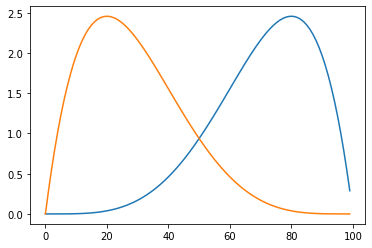

In [ ]:
plt.plot(ss.beta.pdf(np.arange(0,1,.01),a=5,b=2))
plt.plot(ss.beta.pdf(np.arange(0,1,.01),a=2,b=5))

In [ ]:
# dim = 1
# n_comps = 1
# aucpn_range = [0.5, 0.85]
# n_p = 5000
# n_u = 20000
# dg = GaussianMixtureDataGenerator(dim, n_comps, aucpn_range, n_p, n_u,irreducibility_range=[.01,1])
# x, y, y_p = dg.pu_data()
NLP=1000
NUP = 5000
NN = 5000
classPrior = NUP / (NUP + NN)
f0 = ss.beta(a=2,b=5)
f1 = ss.beta(a=5,b=2)
posterior = lambda x: classPrior * f1.pdf(x) / (classPrior * f1.pdf(x) + (1 - classPrior) * f0.pdf(x))
xUnlabeled = np.concatenate((f0.rvs(NN),f1.rvs(NUP)))[:,None]
yPN = np.concatenate((np.zeros(NN),
                    np.ones(NUP))).astype(bool)
xPos = f1.rvs(NLP)[:,None]
xPosTrain, xPosVal = train_test_split(xPos,test_size=.1)
xUnlabeledTrain,xUnlabeledVal,yPNTrain,yPNVal = train_test_split(xUnlabeled,yPN,test_size=.1)

<ipython-input-113-93486b05c4f3>:14: RuntimeWarning: invalid value encountered in true_divide
  posterior = lambda x: classPrior * f1.pdf(x) / (classPrior * f1.pdf(x) + (1 - classPrior) * f0.pdf(x))


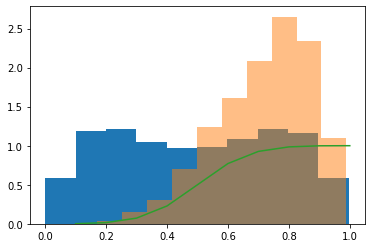

In [ ]:
plt.hist(xUnlabeled,density=True)
plt.hist(xPos,density=True,alpha=.5)
rng = np.arange(-6,6,.1)
plt.plot(rng, posterior(rng))

In [ ]:
class AdversarialAutoencoder:
    def __init__(self, input_shape, h_dim, z_dim, ae_loss_weight, gen_loss_weight, dc_loss_weight):
        self.input_shape = input_shape
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.ae_loss_weight = ae_loss_weight
        self.gen_loss_weight = gen_loss_weight
        self.dc_loss_weight = dc_loss_weight
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.mse = tf.keras.losses.MeanSquaredError()
        self.accuracy = tf.keras.metrics.BinaryAccuracy()
        self.makeModel()
        

    def makeEncoder(self,):
        inputs = tf.keras.Input(shape=(self.input_shape,))
        x = tf.keras.layers.Dense(self.h_dim)(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        encoded = tf.keras.layers.Dense(self.z_dim)(x)
        self.encoder = tf.keras.Model(inputs=inputs, outputs=encoded)
        
    def makeDecoder(self):
        encoded = tf.keras.Input(shape=(self.z_dim,))
        x = tf.keras.layers.Dense(self.h_dim)(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        reconstruction = tf.keras.layers.Dense(self.input_shape, activation=None)(x)
        self.decoder = tf.keras.Model(inputs=encoded, outputs=reconstruction)
        
    def makeDiscriminator(self):
        encoded = tf.keras.Input(shape=(self.z_dim,))
        x = tf.keras.layers.Dense(self.h_dim)(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(self.h_dim)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        prediction = tf.keras.layers.Dense(1)(x)
        self.discriminator = tf.keras.Model(inputs=encoded, outputs=prediction)
        
    def makeModel(self):
        self.makeEncoder()
        self.makeDecoder()
        self.makeDiscriminator()
    
    def autoencoder_loss(self, inputs, reconstruction):
        return self.ae_loss_weight * self.mse(inputs, reconstruction)


    def discriminator_loss(self, real_output, fake_output):
        loss_real = self.cross_entropy(tf.ones_like(real_output), real_output)
        loss_fake = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return self.dc_loss_weight * (loss_fake + loss_real)


    def generator_loss(self, fake_output):
        return self.gen_loss_weight * self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def makeOptimizers(self, base_lr):
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        
    @tf.function
    def aeTrainStep(self,batch_x):
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            encoder_output = self.encoder(batch_x, training=True)
            decoder_output = self.decoder(encoder_output, training=True)

            # Autoencoder loss
            ae_loss = self.autoencoder_loss(batch_x, decoder_output)
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        self.ae_losses.append(ae_loss)

    @tf.function
    def discriminatorTrainStep(self, batch_x):
        # Discriminator
        with tf.GradientTape() as dc_tape:
            real_distribution = tf.reshape(tf.map_fn(lambda x: tf.random.normal([int(batch_x.shape[0] / len(self.m)),],
                                                                               mean=x[0],
                                                                               stddev=x[1]),
                                                    tf.cast(tf.concat([tf.reshape(self.m,(-1,1)),
                                                               tf.reshape(tf.sqrt(self.s), (-1,1))],
                                                              axis=1),tf.float32), dtype=tf.float32),
                                          (-1,self.z_dim))
            encoder_output = self.encoder(batch_x, training=True)

            dc_real = self.discriminator(real_distribution, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)

            # Discriminator Loss
            dc_loss = self.discriminator_loss(dc_real, dc_fake)

            # Discriminator Acc
            dc_acc = self.accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                              tf.concat([dc_real, dc_fake], axis=0))

        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))
        # Log Loss and Accuracy
        self.dc_losses.append(dc_loss)
        self.dc_accs.append(dc_acc)

    @tf.function
    def generatorTrainStep(self, batch_x):
        # Generator (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encoder(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=True)

            # Generator loss
            gen_loss = self.generator_loss(dc_fake)

        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))
        # Log Loss
        self.gen_losses.append(gen_loss)

    @tf.function
    def train_step(self, batch_x):
        self.aeTrainStep(batch_x)
        self.discriminatorTrainStep(batch_x)
        self.generatorTrainStep(batch_x)
     
    def updateMeans(self,):
        embeddingsU = self.encoder(self.xUnlabeled, training=False).numpy()
        embeddingsP = self.encoder(self.xPos,training=False).numpy()
        self.em = MSGMM()
        self.em.fit(embeddingsU, embeddingsP,verbose=True,iterations=50)
        self.m = np.concatenate((self.em.u0,
                                 self.em.u1))
        self.s = np.concatenate((self.em.sigma0,
                                 self.em.sigma1))
        
    def plot(self,):
        X = np.concatenate((self.xUnlabeledVal,self.xPosVal))
        embeddings = self.encoder(X,training=False).numpy()
        resp = self.em.predict_proba(embeddings)
        
#         predPost = resp[:,1] * .5 / (resp[:,1] * .5 + resp[:,0] * .5)
        predPost = resp * self.em.alpha / (resp * self.em.alpha + (1-resp) * (1-self.em.alpha))
        plt.scatter(predPost,posterior(X))
        plt.show()

    def fit(self,xUnlabeled, xPos,validation_data=(np.array([]),np.array([])), n_epochs=100, batch_size=32):
        # Make Dataset
        # Create the dataset iterator
        self.xUnlabeled = xUnlabeled
        self.xPos = xPos
        train_buf = 60000
        train_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate((xUnlabeled,
                                                                           xPos)))
        train_dataset = train_dataset.shuffle(buffer_size=train_buf)
        train_dataset = train_dataset.batch(batch_size)
        (self.xUnlabeledVal, self.xPosVal) = validation_data
        # Define records
        self.ae_losses = []
        self.dc_losses = []
        self.dc_accs = []
        self.gen_losses = []
        # Initialize EM Algorithm
        self.m = np.zeros(2)
        self.s = np.ones(2)
        # Define cyclic learning rate
        base_lr = 0.00025
        max_lr = 0.0025
        batch_size=32
        n_samples = 60000
        step_size = 2 * np.ceil(len(train_dataset) / batch_size)
        global_step = 0
        self.makeOptimizers(base_lr)
        # Start Training
        for epoch in trange(n_epochs):
            start = time.time()

            # Learning rate schedule
            if epoch in [60, 100, 300]:
                base_lr = base_lr / 2
                max_lr = max_lr / 2
                step_size = step_size / 2

                print('learning rate changed!')

            epoch_ae_loss_avg = tf.metrics.Mean()
            epoch_dc_loss_avg = tf.metrics.Mean()
            epoch_dc_acc_avg = tf.metrics.Mean()
            epoch_gen_loss_avg = tf.metrics.Mean()

            for batch, (batch_x) in tqdm(enumerate(train_dataset),leave=False,total=len(train_dataset)):
                # -------------------------------------------------------------------------------------------------------------
                # Calculate cyclic learning rate
                global_step = global_step + 1
                cycle = np.floor(1 + global_step / (2 * step_size))
                x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
                clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
                self.ae_optimizer.lr = clr
                self.dc_optimizer.lr = clr
                self.gen_optimizer.lr = clr

                self.train_step(batch_x)

                epoch_ae_loss_avg(self.ae_losses[-1])
                epoch_dc_loss_avg(self.dc_losses[-1])
                epoch_dc_acc_avg(self.dc_accs[-1])
                epoch_gen_loss_avg(self.gen_losses[-1])

            epoch_time = time.time() - start
            print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
                  .format(epoch, epoch_time,
                          epoch_time * (n_epochs - epoch),
                          epoch_ae_loss_avg.result(),
                          epoch_dc_loss_avg.result(),
                          epoch_dc_acc_avg.result(),
                          epoch_gen_loss_avg.result()))
            self.updateMeans()
            self.plot()

In [ ]:
aae = AdversarialAutoencoder(x.shape[1], 64,1, 1,1,1)

   0: TIME: 19.96 ETA: 1995.59 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.08673388 0.08961686]]

0.2842073736346051 0.7092599486830236 [0.80165066] [0.76067398]

[[0.05764108 0.08646789]]

0.26298463890335705 0.9035425928150015 [0.9321128] [0.69903448]

[[0.02195608 0.06807296]]

0.28127173020761526 0.9643423847802733 [1.03923816] [0.63515284]

[[0.01596714 0.04666878]]

0.35033980657608216 0.8789374215719313 [1.06108609] [0.58372563]

[[0.01662282 0.0386432 ]]

0.3898585520443505 0.8882047234524296 [1.05295451] [0.55891615]

[[0.0182288  0.03447022]]

0.41812206538717706 0.9140352593612632 [1.04218091] [0.54240406]

[[0.01973125 0.03144354]]

0.4406257940676415 0.9334074928517725 [1.03293257] [0.52954843]

[[0.02102781 0.02920685]]

0.458362995698931 0.947045234585757 [1.02539713] [0.5195883]

[[0.02210229 0.0275573 ]]

0.4721368112017664 0.9565514866442888 [1.01942546] [0.51196518]

[[0.02296741 0.02634173]]

0.48270870452023035 0.9631925698240096 [1.01478044

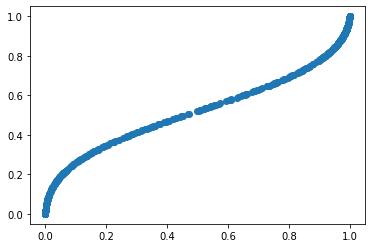

   1: TIME: 2.44 ETA: 241.90 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.022416   0.02288409]]

0.28763848978234685 0.7046807663412773 [-0.43410955] [-0.41532768]

[[0.01497227 0.02228744]]

0.26685241223248546 0.897281403130423 [-0.49910527] [-0.38419109]

[[0.00563312 0.01763973]]

0.2819171995359347 0.9663253819893204 [-0.55458394] [-0.35158176]

[[0.00398864 0.01215341]]

0.3491290626255208 0.8778635289248675 [-0.566678] [-0.32574427]

[[0.00410162 0.01018196]]

0.38570768293238594 0.8829898851565404 [-0.56334438] [-0.31399274]

[[0.00445731 0.00921676]]

0.41080287381998853 0.9065769728556362 [-0.55860455] [-0.30652651]

[[0.0047849  0.00852541]]

0.4304608235210396 0.9245824269185471 [-0.55457945] [-0.30080042]

[[0.0050629  0.00801732]]

0.4457738458261956 0.9374796570118539 [-0.55133343] [-0.29640751]

[[0.00529004 0.00764434]]

0.4575482769863645 0.9466382065243558 [-0.54878316] [-0.29307266]

[[0.00547059 0.00737086]]

0.46650230770704326 0.95313907520

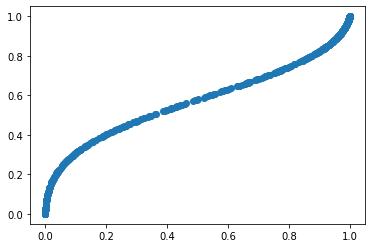

   2: TIME: 4.25 ETA: 416.53 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.17880874 0.1838082 ]]

0.2852454606379921 0.7120976855617758 [-1.15325636] [-1.08982529]

[[0.11651815 0.17775685]]

0.26375187299784963 0.9075768456892566 [-1.33988903] [-1.00123978]

[[0.04489357 0.1396228 ]]

0.28263788358959485 0.9643161407565377 [-1.49079227] [-0.91035721]

[[0.03281614 0.09663347]]

0.35002208213600455 0.8790966334632969 [-1.52157947] [-0.83838819]

[[0.03402997 0.0806529 ]]

0.3881418986702846 0.8873032184971513 [-1.51067802] [-0.80403697]

[[0.03711738 0.0724292 ]]

0.4150943696583874 0.9119368316955614 [-1.49613176] [-0.78143033]

[[0.03997779 0.06651395]]

0.4363229396770974 0.9305215839908662 [-1.48374768] [-0.7640029]

[[0.04241821 0.06217696]]

0.45287717356363233 0.9436758974845331 [-1.47375139] [-0.75063137]

[[0.04441706 0.05900608]]

0.4655926917616106 0.9528918629666676 [-1.46590728] [-0.74050066]

[[0.04600672 0.05669149]]

0.47524193419043087 0.959351662

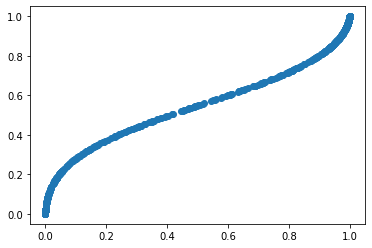

   3: TIME: 2.57 ETA: 249.62 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.05904307 0.06023638]]

0.2856805838458332 0.7085097113154821 [-0.44442937] [-0.41299427]

[[0.04010663 0.05810563]]

0.26445762194900646 0.8999177401058377 [-0.55094395] [-0.36244294]

[[0.01441827 0.04531096]]

0.28423245771048594 0.9615184848963874 [-0.64255437] [-0.30722468]

[[0.0106054  0.02972141]]

0.36009885988489687 0.8796549158035064 [-0.65872726] [-0.26129742]

[[0.01147208 0.02370643]]

0.4067175864780205 0.8997744048514701 [-0.64873538] [-0.23748796]

[[0.01291917 0.02016529]]

0.44251655098377735 0.9290699642202597 [-0.63717459] [-0.22024125]

[[0.01430594 0.01755845]]

0.4715380580493895 0.9494794893452412 [-0.62717076] [-0.20658848]

[[0.01554239 0.01563487]]

0.4946422728190132 0.9630436184480075 [-0.61892962] [-0.19594592]

[[0.01659963 0.01422079]]

0.5127561273410567 0.972073533945778 [-0.61231722] [-0.18776185]

[[0.01747707 0.01318158]]

0.5268145358280568 0.9781741328

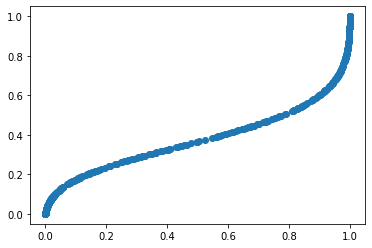

   4: TIME: 2.72 ETA: 261.32 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.03173836 0.03312433]]

0.28716398858080405 0.7105097057217867 [0.04816337] [0.07243064]

[[0.01533607 0.03335131]]

0.27104449976296147 0.9184546333348999 [-0.04014712] [0.11606108]

[[0.00550179 0.02499707]]

0.3250327012436813 0.9498214869329652 [-0.0925952] [0.16158024]

[[0.00462804 0.02001125]]

0.3694356762268943 0.9000160812886315 [-0.09915408] [0.18192736]

[[0.00471907 0.01873102]]

0.38652799121311415 0.9027725532799391 [-0.09773667] [0.18867643]

[[0.00490924 0.01809911]]

0.3980748632161357 0.9125853526241882 [-0.09569473] [0.19291612]

[[0.00508284 0.01760034]]

0.40762461024333563 0.920902299559324 [-0.09387788] [0.19639495]

[[0.00523332 0.01717907]]

0.4157201634497176 0.9275113048852869 [-0.09231308] [0.1993468]

[[0.00536318 0.01682136]]

0.4226040628096797 0.932780456235987 [-0.09096873] [0.20185984]

[[0.0054751  0.01651778]]

0.42845936543853164 0.9370160369617974 [-0.0

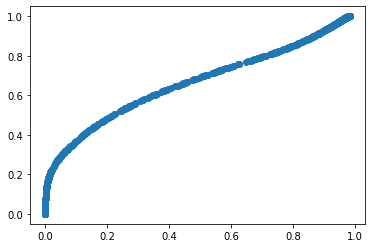





   5: TIME: 51.94 ETA: 4933.86 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.10331903 0.10709549]]

0.28324078693359245 0.7184974746966303 [0.35409182] [0.40014196]

[[0.04688536 0.10708926]]

0.26713369953299315 0.9251601557085171 [0.18784914] [0.48118344]

[[0.0126324  0.07276364]]

0.3424740207634598 0.9118623870506275 [0.0886] [0.57835645]

[[0.01029884 0.05885512]]

0.3752786874670846 0.8570983903829543 [0.0786339] [0.60649124]

[[0.01041838 0.05749161]]

0.3806271718871302 0.858993753386324 [0.07960093] [0.61039375]

[[0.01059884 0.05685955]]

0.3839467265238208 0.8628947815777473 [0.08072521] [0.61268093]

[[0.01074682 0.05636718]]

0.38657152137884004 0.8660123364413833 [0.08163688] [0.61448484]

[[0.01086606 0.05597343]]

0.38866950873547235 0.8684597243888598 [0.08236831] [0.61592685]

[[0.01096204 0.0556582 ]]

0.39034808884503763 0.8703882065726127 [0.08295504] [0.61708072]

[[0.01103926 0.05540573]]

0.39169192775696016 0.8719134559972072 [0.08342

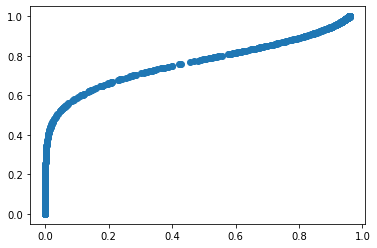

   6: TIME: 2.56 ETA: 240.19 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.14565286 0.15075183]]

0.2846687153598503 0.7098195893304685 [0.50098601] [0.55125384]

[[0.04944839 0.15433712]]

0.2771686331569708 0.9293633923035456 [0.28930571] [0.6595852]

[[0.01138086 0.09829249]]

0.37977473673820494 0.8942059233974589 [0.19018911] [0.79147416]

[[0.00975593 0.0894744 ]]

0.3901137486990215 0.8609510987440212 [0.18280875] [0.80386889]

[[0.00952826 0.0901689 ]]

0.38709958522495674 0.8561330333944798 [0.18155355] [0.80135353]

[[0.00940672 0.09072507]]

0.385052146747385 0.8535570181033992 [0.18085992] [0.79960259]

[[0.00933413 0.09106267]]

0.38381125447660847 0.8519879218195979 [0.18044348] [0.79854146]

[[0.00929063 0.09126559]]

0.3830641795982021 0.8510358822016603 [0.18019325] [0.7979029]

[[0.00926456 0.09138736]]

0.38261536605957813 0.8504612191560131 [0.18004309] [0.79751939]

[[0.00924895 0.09146038]]

0.38234607257176767 0.8501154444791923 [0.17995304]

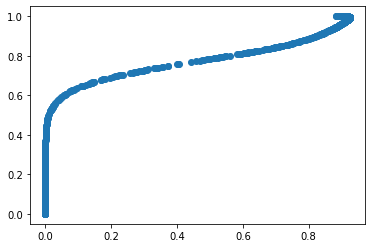

   7: TIME: 3.15 ETA: 292.87 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.15543803 0.16476337]]

0.28432358557242754 0.7222542511999162 [0.34690953] [0.39890058]

[[0.02870592 0.17027727]]

0.30643640621795687 0.9485338463641246 [0.10620001] [0.54047629]

[[0.00794574 0.10859532]]

0.424552886397871 0.9013375498894258 [0.04342253] [0.67981412]

[[0.00748644 0.10695409]]

0.4239781435874275 0.8920760553799406 [0.04089318] [0.68039841]

[[0.00741163 0.10750212]]

0.4221991319306825 0.8907208191755867 [0.04042462] [0.67872566]

[[0.007385   0.10771441]]

0.42152671817879994 0.8902350880805882 [0.04025617] [0.67809082]

[[0.00737523 0.10779266]]

0.4212786612744778 0.8900556804665063 [0.04019421] [0.67785674]

[[0.00737163 0.10782146]]

0.4211873146154915 0.8899895501382209 [0.0401714] [0.67777056]

[[0.00737031 0.10783206]]

0.4211536924907007 0.8899652004340062 [0.04016301] [0.67773884]

[[0.00736982 0.10783596]]

0.4211413192628036 0.8899562383101627 [0.04015992] 

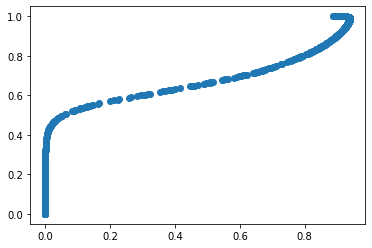

   8: TIME: 2.98 ETA: 274.14 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.12491098 0.13290083]]

0.2852409717572636 0.7135912396831421 [0.09047313] [0.13486184]

[[0.01718634 0.14578427]]

0.3529046485788596 0.9570110605124516 [-0.11257579] [0.28096833]

[[0.01237424 0.10944109]]

0.4883260593215772 0.9733836195457677 [-0.13269463] [0.40874778]

[[0.01322057 0.09656384]]

0.5289129313697715 0.9776783716943007 [-0.12787496] [0.44928616]

[[0.01369479 0.09037008]]

0.5464573842566002 0.9797470586091072 [-0.12507983] [0.46782149]

[[0.01393984 0.08735527]]

0.5546004118223193 0.9806704512899653 [-0.12364429] [0.47664229]

[[0.01406359 0.08589975]]

0.5584685181621528 0.9811057716108877 [-0.12292566] [0.48087363]

[[0.01412481 0.08519811]]

0.5603220090721714 0.9813144333859541 [-0.12257212] [0.48290954]

[[0.01415474 0.08485985]]

0.5612133572861095 0.9814148978981444 [-0.12239989] [0.48389041]

[[0.01416927 0.08469675]]

0.5616426955713905 0.9814633285636297 [-0.12

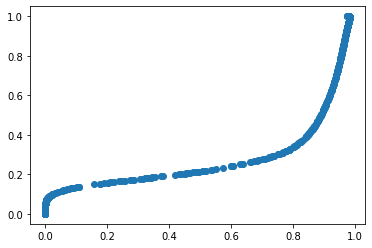

   9: TIME: 2.53 ETA: 230.53 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.20907784 0.22611217]]

0.2860790045641475 0.7166465187001093 [-0.17193262] [-0.10637589]

[[0.0549957  0.24269921]]

0.31207949756938547 0.9480125908546898 [-0.41437911] [0.04059461]

[[0.03917149 0.20268213]]

0.3904438840054525 0.985830354134131 [-0.46585064] [0.1429646]

[[0.03996428 0.19033235]]

0.4264573108835412 0.9864825963224977 [-0.46344441] [0.17897418]

[[0.04147984 0.18500975]]

0.449186743732617 0.9887860737608402 [-0.45751561] [0.19981074]

[[0.04269873 0.18120002]]

0.46559352801568304 0.9905356417429407 [-0.45270434] [0.21509589]

[[0.04361386 0.1781167 ]]

0.47787438249935993 0.9916457980687563 [-0.44906333] [0.22690229]

[[0.04430648 0.17559666]]

0.48723474848928255 0.9923671007041414 [-0.44628634] [0.23614699]

[[0.04483952 0.17354341]]

0.49447080148353023 0.9928596352222052 [-0.44413536] [0.24344502]

[[0.04525572 0.17187315]]

0.5001311446931039 0.9932105706649895 [-

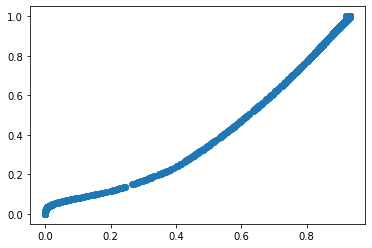

  10: TIME: 4.20 ETA: 377.81 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.85296795 0.9030217 ]]

0.2867369885351155 0.6986922563817121 [-0.39212122] [-0.26860512]

[[0.18640638 0.96260393]]

0.3097130252340837 0.9417025015010004 [-0.91387749] [0.04250378]

[[0.10576695 0.72180036]]

0.4222269487371874 0.9664679972830682 [-1.02557274] [0.33147794]

[[0.11097301 0.64409131]]

0.4639383628873286 0.9692630241165552 [-1.01420201] [0.42534372]

[[0.1170184 0.6027106]]

0.48844749412882577 0.9741576722356372 [-1.00092531] [0.48020907]

[[0.12149261 0.57282143]]

0.5050546348101087 0.9770439396834756 [-0.9911316] [0.51866458]

[[0.12484908 0.55059244]]

0.5168449454202877 0.9788522413199411 [-0.98381884] [0.54664614]

[[0.1274234 0.5339079]]

0.5254585154925776 0.9800815184527917 [-0.97825212] [0.56742169]

[[0.12941953 0.52128665]]

0.5318697636093861 0.9809599493600356 [-0.97397125] [0.58305602]

[[0.13097439 0.51168029]]

0.5367004768596744 0.9816065341694218 [-0.9706

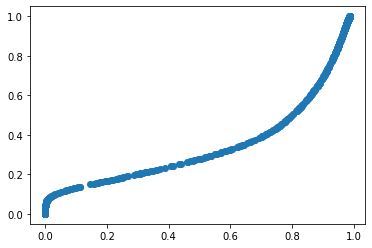

  11: TIME: 3.15 ETA: 280.53 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[2.83577134 3.05044282]]

0.2866944274268928 0.7196426756374912 [-0.51060346] [-0.25889536]

[[0.60460401 3.121383  ]]

0.29914205317524895 0.94649408972543 [-1.51910538] [0.31598108]

[[0.2542691  2.02174042]]

0.43244959672631056 0.9370651372396359 [-1.74909621] [0.95014599]

[[0.27611229 1.68789791]]

0.4747338922122114 0.945340202531338 [-1.71907899] [1.1372109]

[[0.29940164 1.50808606]]

0.4991917533047981 0.9536947685569205 [-1.68962214] [1.24549533]

[[0.31726491 1.38940845]]

0.5151368450964016 0.958615353406044 [-1.66803794] [1.31718641]

[[0.33054264 1.31105139]]

0.5256852706683071 0.9617653080036859 [-1.65263339] [1.36497646]

[[0.34005022 1.25965791]]

0.532645649790508 0.9638439398797358 [-1.64194812] [1.39663369]

[[0.34662613 1.22621864]]

0.5372007581838703 0.965214587606421 [-1.63472521] [1.41739434]

[[0.35105118 1.20462466]]

0.5401557027447991 0.9661100044974088 [-1.62994

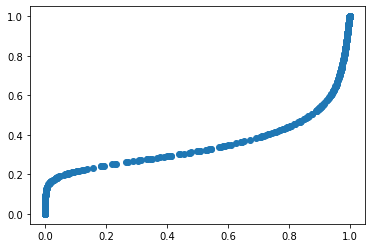

  12: TIME: 2.42 ETA: 212.96 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[4.23183789 4.4949058 ]]

0.2841036287241127 0.7130038422737824 [-0.81228438] [-0.55080099]

[[0.99072999 4.65749047]]

0.2925866145886202 0.9395683089112505 [-2.03130846] [0.12106643]

[[0.41092438 3.09961743]]

0.4270930785047387 0.942651496457712 [-2.33387558] [0.89515125]

[[0.44554772 2.54410339]]

0.47559894171207423 0.9502646448143408 [-2.29502224] [1.15378537]

[[0.48658686 2.22561289]]

0.5050727519460735 0.9592289203160319 [-2.25235679] [1.31229974]

[[0.52119799 2.00130116]]

0.5254889944056931 0.965039811805563 [-2.21822844] [1.42447525]

[[0.54936551 1.84396235]]

0.5398467810692714 0.9690133232808534 [-2.19184553] [1.50423602]

[[0.57104497 1.73600842]]

0.549785347415333 0.9717047546008994 [-2.17240107] [1.55974677]

[[0.58677348 1.66397819]]

0.5564787982522728 0.9734722667088909 [-2.15875759] [1.59722126]

[[0.59761583 1.61715531]]

0.5608645692940499 0.9746021465529853 [-2.14

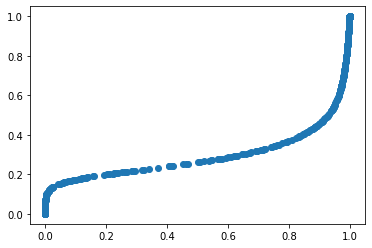

  13: TIME: 2.55 ETA: 221.62 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[3.505779  3.7338554]]

0.28436842097881887 0.7037939738286358 [-0.35430522] [-0.09188218]

[[0.85397183 3.82814333]]

0.2885527949980754 0.9371870478437121 [-1.46247961] [0.50840934]

[[0.31422322 2.43109355]]

0.4290748945889189 0.9332832391423748 [-1.75361708] [1.24988717]

[[0.34789227 1.91078412]]

0.48123625542815535 0.9441928302276501 [-1.71022545] [1.50728464]

[[0.38393351 1.61618235]]

0.5117069288763607 0.9539414851844353 [-1.66781218] [1.66031236]

[[0.41108611 1.44301492]]

0.5297318059213388 0.9592368128745392 [-1.6385143] [1.75185133]

[[0.42884973 1.34988824]]

0.5396818561716771 0.9622000037903679 [-1.62073451] [1.80234223]

[[0.43915693 1.30211681]]

0.5448994529787734 0.9638178970567434 [-1.61090469] [1.82874266]

[[0.44470033 1.27812144]]

0.5475563070320024 0.9646668426557266 [-1.60575847] [1.84215642]

[[0.44755921 1.26618011]]

0.5488884891385682 0.9650998836638885 [-1.6

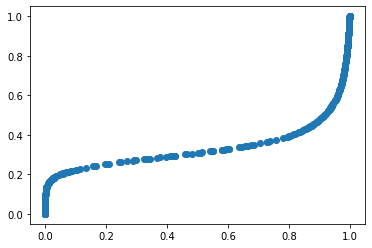

  14: TIME: 2.01 ETA: 173.00 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[2.01140642 2.12842846]]

0.28450384382008653 0.7194343442261045 [0.17625664] [0.37259812]

[[0.47657936 2.18263736]]

0.29085132220893367 0.9425461938673223 [-0.66745926] [0.83496997]

[[0.15070854 1.36552255]]

0.42413930366859004 0.9148324951558117 [-0.90617943] [1.38116058]

[[0.15945872 1.16751999]]

0.45730641210556133 0.9204712117174262 [-0.89029453] [1.50542869]

[[0.16783225 1.09497895]]

0.47100353471481465 0.9274519833238967 [-0.87719041] [1.55596374]

[[0.17235928 1.06099681]]

0.4774502590187636 0.9309662346440206 [-0.87039614] [1.5798837]

[[0.17467835 1.04473768]]

0.4805478583198386 0.9326930962657971 [-0.86698929] [1.59139721]

[[0.17583705 1.03688645]]

0.48204803355939535 0.9335371277075245 [-0.86530541] [1.59697594]

[[0.17640876 1.03307715]]

0.4827770899260519 0.9339489424336517 [-0.864479] [1.5996875]

[[0.17668911 1.03122454]]

0.4831319605026054 0.9341497565081036 [-0.

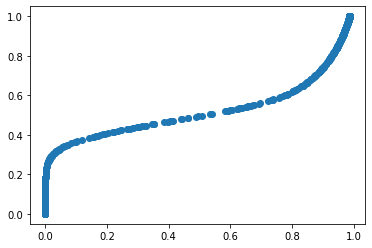

  15: TIME: 3.22 ETA: 274.08 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.82521422 0.88587701]]

0.28661539992176693 0.710930384441538 [-0.00621926] [0.11730407]

[[0.181414   0.92996367]]

0.30829308218365165 0.9460459437982377 [-0.53094295] [0.42858101]

[[0.09038419 0.6779105 ]]

0.41843936836282875 0.9512299585063437 [-0.65224737] [0.71587977]

[[0.09347582 0.60926345]]

0.4524826019933922 0.9525098291972737 [-0.64490668] [0.79325155]

[[0.09738638 0.58008763]]

0.4693546385270002 0.9577803196074639 [-0.63604155] [0.83066767]

[[0.099874   0.56288136]]

0.47906025603132985 0.9608836538537713 [-0.63048105] [0.8525641]

[[0.10141446 0.55244591]]

0.48482062732470443 0.9626850271433485 [-0.62706267] [0.86571407]

[[0.10236647 0.54609068]]

0.4882878373172698 0.9637532311674001 [-0.62496067] [0.8736822]

[[0.10295359 0.54221126]]

0.4903907843047892 0.9643952063094381 [-0.6236687] [0.87853363]

[[0.10331499 0.53983944]]

0.49167181860382414 0.9647840640964102 [-0

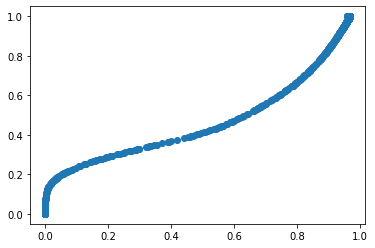

  16: TIME: 1.91 ETA: 160.80 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.42443866 0.45038254]]

0.2856376502725726 0.7171760392414944 [-0.17739402] [-0.08582758]

[[0.12281572 0.47786135]]

0.2984118348397977 0.9424065607958044 [-0.52415408] [0.11123008]

[[0.07172681 0.38528901]]

0.3715889583675955 0.9747146356320479 [-0.62405093] [0.26244273]

[[0.07063858 0.3551032 ]]

0.4024766270322338 0.9690604019203197 [-0.62742547] [0.31000324]

[[0.07247936 0.34485761]]

0.4186061968703055 0.9716183282003092 [-0.6222638] [0.33173756]

[[0.07409753 0.33902326]]

0.42912872042192923 0.974311883009867 [-0.61777564] [0.34557019]

[[0.07527699 0.33496569]]

0.4364334408448961 0.9761750667682138 [-0.61451066] [0.3552403]

[[0.07612132 0.33203053]]

0.44160586649052214 0.9774358412595385 [-0.61217201] [0.36215527]

[[0.07672847 0.32989215]]

0.44530749646503975 0.9783053122207988 [-0.6104889] [0.36714242]

[[0.0771676 0.3283307]]

0.4479758472237295 0.9789157724721779 [-0.609

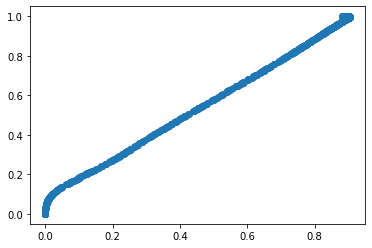

  17: TIME: 3.84 ETA: 318.61 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.36464233 0.38141589]]

0.2861951224605205 0.7141990441125171 [-0.14219902] [-0.06260671]

[[0.11285705 0.4066593 ]]

0.2945723153162032 0.936863875632347 [-0.45777552] [0.11296877]

[[0.06369797 0.32918018]]

0.363428625505286 0.9758517035528605 [-0.55857508] [0.25067838]

[[0.06204979 0.30226721]]

0.3944497478972446 0.9686223288100302 [-0.56382306] [0.29519594]

[[0.06345689 0.29333972]]

0.4104361172126059 0.9706639074266966 [-0.55955147] [0.31501058]

[[0.0648136  0.28848589]]

0.42081018636916034 0.9734103157358956 [-0.55549821] [0.32740686]

[[0.06582585 0.28515178]]

0.4280478738206405 0.9753898962561973 [-0.55248348] [0.33607739]

[[0.06655778 0.28273412]]

0.43320892825154245 0.9767467407003699 [-0.55030257] [0.34231279]

[[0.06708772 0.28096276]]

0.4369279852649259 0.9776884758019029 [-0.54872191] [0.34683881]

[[0.06747336 0.2796614 ]]

0.43962643704420196 0.9783529994510013 [-0

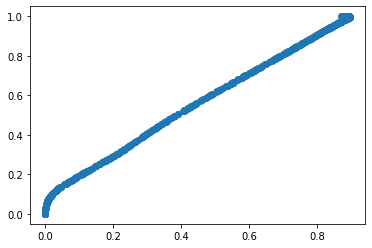

  18: TIME: 3.18 ETA: 260.42 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.33429008 0.35552877]]

0.2853639172300047 0.7145681836892743 [-0.07923821] [-0.00077953]

[[0.09943919 0.37636554]]

0.29616303595936083 0.9401020216833856 [-0.3877725] [0.17250023]

[[0.05669403 0.30282599]]

0.3689911617288985 0.9736282173139243 [-0.4799514] [0.30770189]

[[0.05572361 0.27806228]]

0.40083110618698176 0.9671606351464632 [-0.48324531] [0.35120453]

[[0.05718022 0.26947626]]

0.41750966567199727 0.9698821754324454 [-0.47858308] [0.37126563]

[[0.05846798 0.26454501]]

0.4283690641996524 0.9727942095607104 [-0.47451643] [0.38404299]

[[0.05940483 0.26111723]]

0.4358824317899711 0.9748068814262938 [-0.47156414] [0.39295316]

[[0.06007354 0.2586462 ]]

0.44118205509926695 0.9761644990149163 [-0.46945538] [0.39930165]

[[0.06055282 0.25685375]]

0.44495901988368064 0.9770972576114288 [-0.46794255] [0.40386148]

[[0.06089824 0.25555101]]

0.44766987930065916 0.9777495656876182 

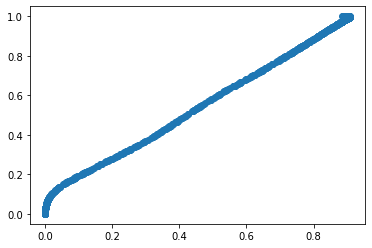

  19: TIME: 2.68 ETA: 216.87 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.33219928 0.35249769]]

0.28698918011558083 0.7205759617387748 [-0.0170471] [0.06101416]

[[0.09585232 0.37291409]]

0.2982865658075948 0.9423871363183455 [-0.32760459] [0.23701344]

[[0.05310985 0.29585496]]

0.3757860022433872 0.9703574613746183 [-0.41891784] [0.37814034]

[[0.05245859 0.27043283]]

0.40843998330597425 0.9639047171557026 [-0.42103589] [0.42280334]

[[0.05397649 0.26135574]]

0.4254763883397621 0.9672994948037409 [-0.41604584] [0.44366999]

[[0.0552396  0.25596526]]

0.4364854360527975 0.9704462230966775 [-0.41195676] [0.45700439]

[[0.05613692 0.25223051]]

0.44399054603359744 0.9725411051117925 [-0.40905734] [0.46619337]

[[0.05676733 0.24957997]]

0.44919798616571194 0.9739266986639835 [-0.40701928] [0.47263544]

[[0.05721257 0.24769161]]

0.4528476629861909 0.9748636522892785 [-0.40557908] [0.47718418]

[[0.05752865 0.24634402]]

0.45542335431205566 0.9755088941409196 [

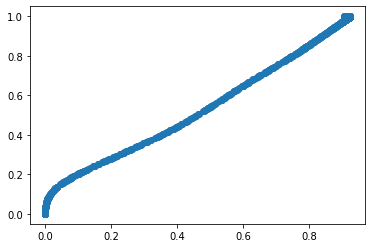

  20: TIME: 4.06 ETA: 324.57 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.33716586 0.35643183]]

0.2852007239564825 0.7213337634547979 [0.00805464] [0.08685277]

[[0.09658603 0.376848  ]]

0.2961785070215765 0.9423731518925951 [-0.30587415] [0.26325121]

[[0.05294031 0.29785846]]

0.37560191037880425 0.9689037998304723 [-0.39809568] [0.40713113]

[[0.05233313 0.27132581]]

0.40910590033229677 0.962266156345984 [-0.40002338] [0.45323751]

[[0.05392031 0.26169213]]

0.42658128667636425 0.9659827822212851 [-0.3948218] [0.47491987]

[[0.05523628 0.2559184 ]]

0.4378902715529579 0.9693459049644165 [-0.39057695] [0.48882379]

[[0.05617303 0.25190677]]

0.44561293449732486 0.9715745886261951 [-0.38756062] [0.49842509]

[[0.05683337 0.24905487]]

0.4509825931204341 0.9730473245695935 [-0.38543311] [0.50517034]

[[0.05730147 0.24701911]]

0.4547552526715434 0.974043708503546 [-0.38392421] [0.50994459]

[[0.05763502 0.24556298]]

0.457425039870668 0.9747307977555053 [-0.38

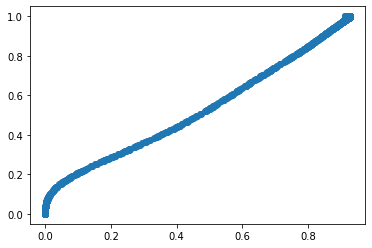

  21: TIME: 2.45 ETA: 193.25 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.3612095  0.38197449]]

0.2830899932115726 0.7167555569957016 [0.00142157] [0.07959996]

[[0.10698415 0.40307684]]

0.29186391691297364 0.9389938492801436 [-0.3241069] [0.25881266]

[[0.05763972 0.31867625]]

0.37038425042462336 0.9688410711205839 [-0.42373863] [0.4074786]

[[0.05662341 0.2892386 ]]

0.40431565291635363 0.9611002572571159 [-0.4267339] [0.45594607]

[[0.05831793 0.27880179]]

0.4218678566039507 0.9647752079062123 [-0.42137022] [0.47835992]

[[0.05979713 0.27262061]]

0.4333606497614545 0.9683825292590819 [-0.41678519] [0.49281057]

[[0.0608756  0.26826561]]

0.4413623684263103 0.9708253415226709 [-0.41345037] [0.5029697]

[[0.06165118 0.26510557]]

0.4470419587478903 0.9724625508060146 [-0.41105037] [0.5102552]

[[0.06221219 0.26280044]]

0.4511169938951195 0.97358642928129 [-0.40931316] [0.51552256]

[[0.06262038 0.26111485]]

0.4540629905401242 0.97437407437707 [-0.40804867

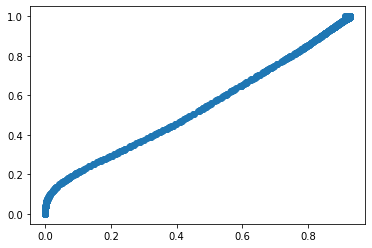

  22: TIME: 3.79 ETA: 295.45 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.41887145 0.43490465]]

0.2856394206273036 0.7170664264203336 [-0.08062314] [0.00038916]

[[0.13786015 0.45994096]]

0.2878728404363444 0.9332897896284956 [-0.42108521] [0.18363583]

[[0.0697183  0.36325667]]

0.35785912541432263 0.9697991917624005 [-0.54404541] [0.33934438]

[[0.06636308 0.32680291]]

0.3900157977272098 0.9560985040298702 [-0.55266812] [0.39042721]

[[0.06769896 0.31558561]]

0.40509577148182047 0.9580857804701458 [-0.54862158] [0.4110956]

[[0.06923086 0.30983088]]

0.4147678782018148 0.9618388131616563 [-0.5442782] [0.42369798]

[[0.07042239 0.30586683]]

0.4216582193894402 0.9646606287883974 [-0.54093047] [0.43264885]

[[0.07130597 0.30293844]]

0.42669221023095766 0.9666302112593994 [-0.53844919] [0.43922855]

[[0.07195987 0.30074914]]

0.4304038186307324 0.9680158613586428 [-0.5366114] [0.44410873]

[[0.07244576 0.29910857]]

0.4331556161547475 0.9690066672378594 [-0.5

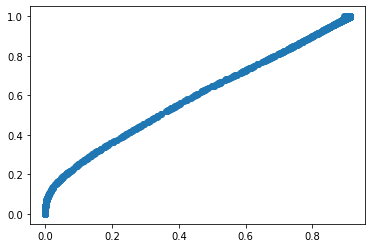

  23: TIME: 3.69 ETA: 284.15 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.56258453 0.58594658]]

0.2875856302464087 0.7128575301432789 [-0.25998616] [-0.15928873]

[[0.21178824 0.61005896]]

0.28207730873214365 0.9285293130105899 [-0.64542029] [0.04224773]

[[0.09626969 0.47567792]]

0.3432213131082001 0.964307151359438 [-0.8128551] [0.22112336]

[[0.08757694 0.4162095 ]]

0.3770979931631532 0.937584949762454 [-0.83053925] [0.28564192]

[[0.08842661 0.39894529]]

0.3912487541667459 0.9374833706014235 [-0.82767092] [0.30904399]

[[0.0902541  0.39116996]]

0.39977763942359157 0.9418768123181064 [-0.82312213] [0.32215772]

[[0.09177871 0.38605366]]

0.40582696001627394 0.9455462598260558 [-0.81942493] [0.33132757]

[[0.09293944 0.38230509]]

0.41028567337823635 0.9482304762711513 [-0.81662389] [0.3380934]

[[0.09381332 0.37949835]]

0.4136083234349289 0.9501784708770474 [-0.81451749] [0.34314991]

[[0.09447161 0.37738576]]

0.41609723490046036 0.9516038242039141 [-0

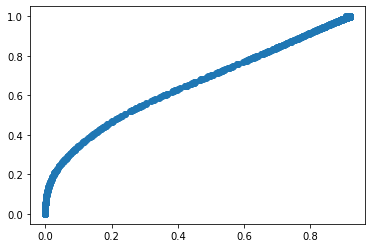

  24: TIME: 4.37 ETA: 332.06 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.83479786 0.88445996]]

0.28481217603919845 0.727083633750396 [-0.43416773] [-0.29429281]

[[0.30867658 0.90369608]]

0.27832777218332605 0.9375678928966646 [-0.91676153] [-0.04480938]

[[0.13950377 0.69175971]]

0.34497575769907873 0.957053931363826 [-1.11537695] [0.17866219]

[[0.12907639 0.59632847]]

0.38276236130191965 0.9319932581266577 [-1.13178545] [0.26433676]

[[0.13234545 0.56508792]]

0.4007429971153814 0.9359616295462467 [-1.12400186] [0.30034613]

[[0.13652803 0.54775423]]

0.41285440791844574 0.9426770378973024 [-1.11527632] [0.32359283]

[[0.13998107 0.53505515]]

0.42195378512629156 0.9478707786700628 [-1.10818866] [0.34104243]

[[0.14271333 0.52523283]]

0.42895754708876216 0.951682477959256 [-1.10260025] [0.35454094]

[[0.14487156 0.51756006]]

0.4343973112885453 0.95450682030563 [-1.09819436] [0.36507076]

[[0.14657937 0.5115457 ]]

0.4386449739529945 0.9566283046173374 [

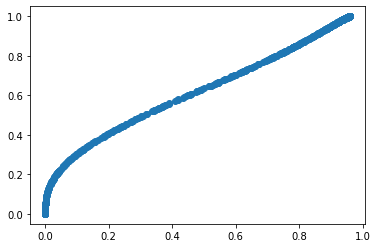

  25: TIME: 3.50 ETA: 262.81 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.15127823 1.20147525]]

0.28388148585289974 0.7111078029197142 [-0.24525496] [-0.10657184]

[[0.4240697  1.23587872]]

0.27601405190343076 0.9273166985757021 [-0.82040013] [0.18606193]

[[0.16038417 0.90508513]]

0.36057531606013543 0.9442443856421447 [-1.0677438] [0.4951358]

[[0.1538476  0.75967893]]

0.4044191443347529 0.9275985066103973 [-1.07497962] [0.61045788]

[[0.16210878 0.7052665 ]]

0.4275241423461793 0.9372680139853373 [-1.05874162] [0.66593562]

[[0.16983841 0.66861531]]

0.4440756333929694 0.9457052209638912 [-1.04427721] [0.70550056]

[[0.17612086 0.64072284]]

0.45660041516345157 0.9516799932533813 [-1.03268639] [0.73571696]

[[0.18119209 0.6192503 ]]

0.46620911920672087 0.9559763031818213 [-1.02344517] [0.75905438]

[[0.18527252 0.60268616]]

0.47362532769867793 0.9591280695437926 [-1.01609695] [0.77714447]

[[0.1885376 0.5898979]]

0.4793641643852196 0.9614702560523318 [-

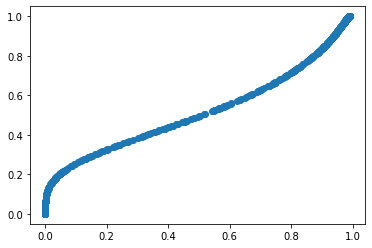

  26: TIME: 2.52 ETA: 186.74 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.27822286 1.34745741]]

0.2839564822855765 0.7102984408231643 [0.20221984] [0.35816058]

[[0.466751  1.3697155]]

0.2748820168572783 0.9292733252306284 [-0.41523534] [0.67106462]

[[0.15019245 0.9473752 ]]

0.36830250119350844 0.9250779948375416 [-0.68944138] [1.02680236]

[[0.14287415 0.78869206]]

0.4074120884697703 0.9067627152735153 [-0.69617861] [1.13866923]

[[0.15073621 0.74030119]]

0.4249245172944968 0.9170036671491743 [-0.68163133] [1.18408806]

[[0.15740191 0.70979746]]

0.4366848795196445 0.9250804310919051 [-0.66995893] [1.21434607]

[[0.1624791  0.68813195]]

0.4450759355319292 0.930657412823365 [-0.66123429] [1.23600114]

[[0.16631914 0.67246252]]

0.4511631756583737 0.9345537642144361 [-0.65472173] [1.25174041]

[[0.16921352 0.66104056]]

0.45561543751893807 0.9373153165617746 [-0.64986203] [1.26326289]

[[0.17138786 0.65267432]]

0.45888700326899834 0.9392947780334978 [-0.64

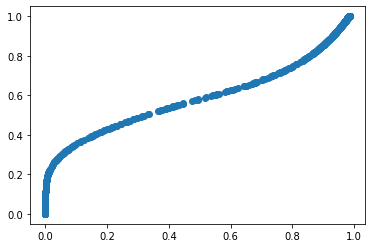

  27: TIME: 2.26 ETA: 164.93 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.23637041 1.27950109]]

0.28958955824651933 0.7101880867267963 [0.39539943] [0.54582045]

[[0.44230304 1.31880685]]

0.28132381148856983 0.9284390329249433 [-0.1994475] [0.85527504]

[[0.1446176  0.91829322]]

0.3720080269124145 0.9317010353263807 [-0.46626872] [1.20200243]

[[0.13570198 0.78049567]]

0.4060366895434665 0.9110752456279134 [-0.47683236] [1.29917285]

[[0.14154372 0.74491148]]

0.41998603635413345 0.9187385474114211 [-0.46595905] [1.33414667]

[[0.146771   0.72253133]]

0.42962868550008687 0.9254730016684658 [-0.45671783] [1.35793336]

[[0.15082804 0.70581972]]

0.43681032031432915 0.9302968758077463 [-0.4496177] [1.37572765]

[[0.15396669 0.6931114 ]]

0.4422403399320804 0.9337841216500227 [-0.44415855] [1.38923657]

[[0.15640016 0.68339422]]

0.44637715917450166 0.9363460897056489 [-0.43994678] [1.39955773]

[[0.158289   0.67593903]]

0.4495440460004508 0.9382523907665963 [-

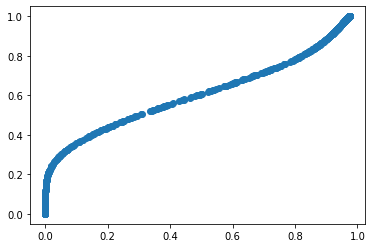

  28: TIME: 3.66 ETA: 263.58 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.92376021 0.96878268]]

0.2853547204880287 0.7063646386746231 [0.06385634] [0.19067086]

[[0.33448834 1.00514534]]

0.28051821497989254 0.9274527073746076 [-0.44262875] [0.45382369]

[[0.14595206 0.76820087]]

0.35179439247027183 0.9582423593601119 [-0.6536582] [0.70079052]

[[0.13540098 0.66853257]]

0.387676867520994 0.9352310540398026 [-0.67000872] [0.78700913]

[[0.13853593 0.63889822]]

0.40349477854024945 0.9385468390629045 [-0.66306277] [0.82032119]

[[0.14238655 0.62327512]]

0.4137607674846477 0.9441963417357978 [-0.65549767] [0.84097277]

[[0.14546478 0.61214796]]

0.4212681502445519 0.9484939239004848 [-0.64954149] [0.85605047]

[[0.14782595 0.60373868]]

0.42690266457496495 0.9515934389592994 [-0.64498751] [0.86742276]

[[0.14963537 0.59731425]]

0.43117231471682604 0.953849477374151 [-0.64150231] [0.8760784]

[[0.15102588 0.59238821]]

0.43442642628714 0.9555138545665287 [-0.638

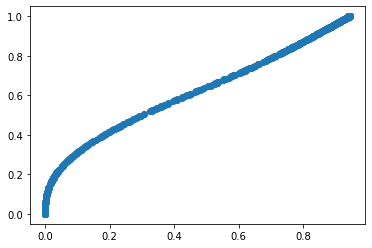

  29: TIME: 2.74 ETA: 194.61 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.01376984 1.05661624]]

0.28432705840616546 0.7175155108169544 [-0.53734074] [-0.40548928]

[[0.50270742 1.06694119]]

0.26901218342096134 0.919007437339204 [-1.0289929] [-0.16454198]

[[0.20193805 0.83557445]]

0.3090634377565423 0.9611294770410965 [-1.32111997] [0.06087721]

[[0.16512394 0.67931179]]

0.35323772002893716 0.9034514567315675 [-1.37027869] [0.17495652]

[[0.1643122  0.63073257]]

0.37175575888759477 0.8990000685069955 [-1.36775501] [0.21688031]

[[0.16879725 0.61052151]]

0.38262630259446134 0.9064926837128221 [-1.35870685] [0.23942751]

[[0.17293099 0.59708956]]

0.3905610374701388 0.9132350572339138 [-1.35087354] [0.25557909]

[[0.17624708 0.58702827]]

0.39660656057686566 0.9183765674809689 [-1.34467735] [0.26786139]

[[0.17886046 0.57934017]]

0.4012535978844075 0.9222535764838591 [-1.3398292] [0.27730253]

[[0.18091176 0.57343698]]

0.40483712442486225 0.9251905819221934

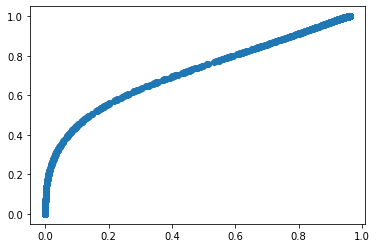

  30: TIME: 2.27 ETA: 159.13 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.6371868 1.6962854]]

0.2866423525133376 0.6990256157173913 [-1.15066618] [-0.98147815]

[[0.9034669  1.69916825]]

0.26845980253129254 0.9060991654619521 [-1.74584295] [-0.69246698]

[[0.3448629  1.33345812]]

0.30179520395125653 0.9616701947282246 [-2.15357482] [-0.40298069]

[[0.27671443 1.04185062]]

0.3533554248724115 0.9002839898608199 [-2.22240854] [-0.23540251]

[[0.27895215 0.93972919]]

0.3786345021556994 0.8996148161931025 [-2.21162129] [-0.16406648]

[[0.29144036 0.89025961]]

0.39523737202232434 0.9118835443204212 [-2.19151475] [-0.12050691]

[[0.30299088 0.85470126]]

0.40804934389201925 0.9222945095397643 [-2.17395357] [-0.0873176]

[[0.31268051 0.82729923]]

0.4181507800372028 0.9302284840173936 [-2.15953856] [-0.06122336]

[[0.3206516  0.80605531]]

0.42611627366237576 0.9362376310645489 [-2.14787502] [-0.04069288]

[[0.3271306  0.78959324]]

0.4323804053671273 0.94079968525

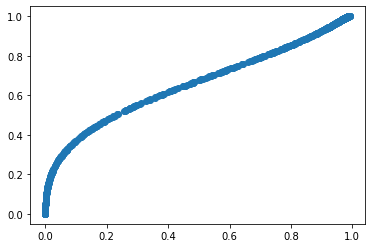

  31: TIME: 3.17 ETA: 218.62 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.38990277 1.44339   ]]

0.28463728060279553 0.712244652054171 [-0.6979678] [-0.5242477]

[[0.69769679 1.4500028 ]]

0.26793379380500765 0.919067152920118 [-1.26644869] [-0.24693768]

[[0.27425857 1.12495656]]

0.3092348045633451 0.957881978653657 [-1.61268278] [0.02112417]

[[0.22436098 0.89877689]]

0.35632964503173625 0.8988703317274546 [-1.66815798] [0.16192996]

[[0.22577732 0.82711152]]

0.37710901840566957 0.8980289926010904 [-1.66081678] [0.2163401]

[[0.23390677 0.79405733]]

0.3901634815540837 0.9078097524985669 [-1.6468757] [0.24806002]

[[0.24120693 0.77088644]]

0.39997798719632055 0.9160986657174358 [-1.63498441] [0.27160153]

[[0.24716646 0.75323527]]

0.4075815432206219 0.9224141160033623 [-1.62543379] [0.28980834]

[[0.25196421 0.73962042]]

0.4135067794139215 0.9272099662854097 [-1.61782932] [0.30398413]

[[0.25580385 0.72908213]]

0.41813282304819543 0.9308703926955024 [-1.

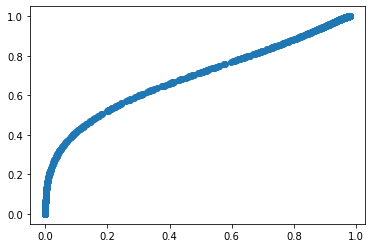

  32: TIME: 2.39 ETA: 162.76 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.70528962 0.74453674]]

0.2840591488025438 0.709330502449157 [0.11589869] [0.22849911]

[[0.2509939  0.77527115]]

0.2817675292707259 0.9301311755474158 [-0.32459048] [0.45920862]

[[0.1252573  0.61400217]]

0.34788266784357996 0.9683240195562416 [-0.49261243] [0.65688817]

[[0.11940017 0.54445973]]

0.38516222258763777 0.9538033555843208 [-0.50392091] [0.73214423]

[[0.12240635 0.51863686]]

0.4049506633477524 0.9569130912298993 [-0.49667273] [0.76754117]

[[0.12584283 0.50368232]]

0.41835090048595985 0.9618932017937181 [-0.48893628] [0.79075309]

[[0.12860546 0.49281272]]

0.428217517734485 0.9656359530816745 [-0.48276575] [0.80790653]

[[0.13073837 0.48449429]]

0.43565886931130093 0.9682871581879811 [-0.47799709] [0.82095872]

[[0.13238699 0.47806286]]

0.4413349489499535 0.9701936518652873 [-0.47430577] [0.83098886]

[[0.13366806 0.47307182]]

0.4456977803168387 0.9715935909170179 [-0.

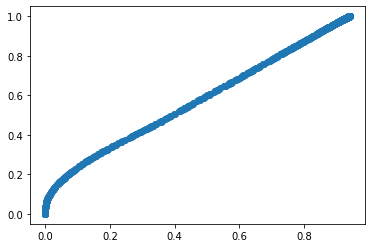

  33: TIME: 1.49 ETA: 99.62 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.67689084 0.71636742]]

0.28605301669281724 0.7100936146871153 [0.5390916] [0.65252749]

[[0.18394448 0.74731103]]

0.2930836701239607 0.9390210981212166 [0.07742532] [0.90785574]

[[0.08167218 0.54432348]]

0.39148977885800407 0.9484443391614753 [-0.06442769] [1.15471639]

[[0.08112071 0.48368792]]

0.4242089812262931 0.9414127351460401 [-0.06454891] [1.22193038]

[[0.08452813 0.46295262]]

0.44007292676883353 0.9477452694815983 [-0.05633518] [1.25171033]

[[0.08718852 0.4499023 ]]

0.45047231494197615 0.9524622441977364 [-0.05007552] [1.27120198]

[[0.08909936 0.44073575]]

0.4576641418034754 0.9555696083420043 [-0.04560616] [1.28480972]

[[0.09047533 0.43419114]]

0.46273191238783673 0.9576652032718295 [-0.04239903] [1.2944678]

[[0.09147162 0.42948617]]

0.46634393359462734 0.9591120756611115 [-0.04008306] [1.30138567]

[[0.09219558 0.4260876 ]]

0.46893822165892024 0.960127695984432 [-0.

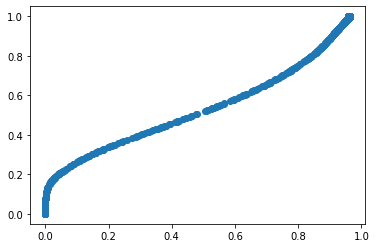

  34: TIME: 2.23 ETA: 147.48 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.74889104 0.78194232]]

0.28826951570640974 0.7227412061150655 [0.64565226] [0.76110441]

[[0.20436323 0.81676568]]

0.2931463734759562 0.9407737130606292 [0.15918132] [1.02970676]

[[0.0849732  0.58022914]]

0.3970024931283144 0.9445595437725707 [0.00634152] [1.30224915]

[[0.08541326 0.51001418]]

0.4316264835071857 0.9399966070098221 [0.00896083] [1.37694162]

[[0.08967694 0.48359896]]

0.4493380780061641 0.9472264323879394 [0.01907806] [1.41240189]

[[0.09295581 0.4660855 ]]

0.4611998911689255 0.9522613633290544 [0.02667665] [1.4363192]

[[0.09535628 0.45358056]]

0.4695077573189238 0.9555855348378965 [0.03218984] [1.45326408]

[[0.09712407 0.44454235]]

0.47543713491068046 0.9578584225417762 [0.03622193] [1.46545421]

[[0.09843147 0.43796497]]

0.4797191287565382 0.9594521988920601 [0.0391872] [1.47430494]

[[0.0994001  0.43315517]]

0.48283528544757914 0.9605880592367393 [0.04137437] 

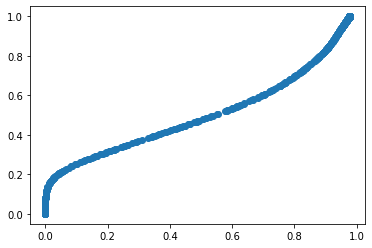

  35: TIME: 2.31 ETA: 150.40 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.66105061 0.70065193]]

0.28567354980844717 0.7104077359681741 [0.50494112] [0.61544202]

[[0.16757876 0.73395364]]

0.29695564296800564 0.9408428832522323 [0.04460784] [0.87469739]

[[0.07953765 0.53704772]]

0.4010965866985123 0.952663167823424 [-0.08195241] [1.12360077]

[[0.0808946  0.47659664]]

0.43739634611668066 0.9504499032779965 [-0.07778308] [1.19632373]

[[0.08479085 0.45169101]]

0.4565202160383669 0.9570191398487958 [-0.06814294] [1.23261461]

[[0.08771266 0.43534015]]

0.4690479824822501 0.9614950946949931 [-0.06104393] [1.25667108]

[[0.08980801 0.42385744]]

0.4776380667722805 0.9643739250368324 [-0.05598434] [1.2733922]

[[0.09131865 0.41569687]]

0.4836476534575005 0.9662835744500431 [-0.0523533] [1.28519819]

[[0.09241224 0.40986278]]

0.4879025442150677 0.9675830663058802 [-0.04973466] [1.29360806]

[[0.09320534 0.40567518]]

0.490937965374806 0.9684833950258839 [-0.0478

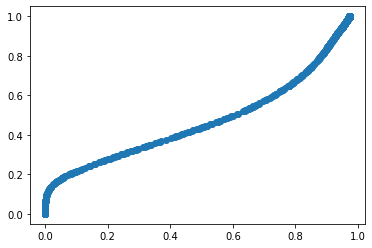

  36: TIME: 2.36 ETA: 150.81 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.52703513 0.55861458]]

0.28652087833479073 0.7123887850183312 [0.29516309] [0.39065892]

[[0.14585265 0.59046049]]

0.29718307855151405 0.9394647534026277 [-0.10279985] [0.61473618]

[[0.07869933 0.45944178]]

0.38691918976674405 0.9674074120746265 [-0.21413658] [0.80982814]

[[0.07949244 0.41246188]]

0.42634737006810314 0.9645384763110899 [-0.21219327] [0.87750558]

[[0.08275005 0.39150892]]

0.44862854390433565 0.9695020905064943 [-0.20345483] [0.91367508]

[[0.08531166 0.37750364]]

0.4635177404241542 0.9731371752250024 [-0.19662282] [0.93817141]

[[0.08719102 0.36736878]]

0.47394392387064244 0.9754767289658026 [-0.19160672] [0.95563642]

[[0.08858162 0.35993269]]

0.4814186511231668 0.9770448036755324 [-0.18789658] [0.96832003]

[[0.08962074 0.35443761]]

0.4868628435227457 0.9781373567585764 [-0.18512876] [0.97763982]

[[0.09040187 0.35035284]]

0.4908725303461896 0.9789187028640933 

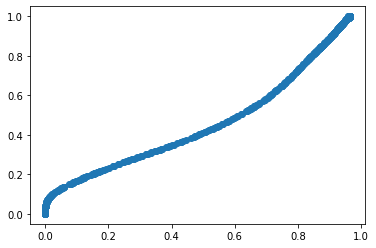

  37: TIME: 2.76 ETA: 174.18 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.39204606 0.41415964]]

0.2826127750197458 0.7172333082740624 [0.04939564] [0.13673841]

[[0.14020586 0.43466473]]

0.28321988501769235 0.933905298089428 [-0.27057404] [0.30601015]

[[0.08293934 0.36112173]]

0.33841124453524307 0.9811998297278872 [-0.38139932] [0.43100185]

[[0.08054677 0.3301188 ]]

0.3733639179436318 0.9750240302147055 [-0.38912852] [0.48112361]

[[0.08217887 0.31691083]]

0.3947050976574742 0.9763093400473088 [-0.38431071] [0.50796752]

[[0.08408618 0.30896441]]

0.40963943709278755 0.9793705007583955 [-0.37875902] [0.52616535]

[[0.08567305 0.30314805]]

0.4208012279265758 0.9818801852708109 [-0.37413556] [0.53981081]

[[0.08692193 0.29860551]]

0.42936466850225374 0.9837030926063656 [-0.37047193] [0.55039979]

[[0.08790051 0.29499553]]

0.4360249487804511 0.9850196756935148 [-0.36757972] [0.55872652]

[[0.08867139 0.29211128]]

0.4412521720833793 0.9859857899475836 [-0

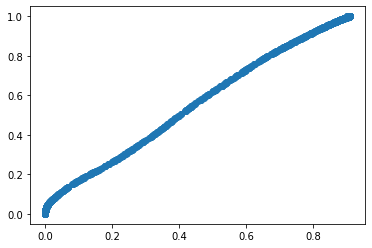

  38: TIME: 2.23 ETA: 138.16 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.35199181 0.36638607]]

0.28512494618052037 0.7168170595796464 [-0.16214791] [-0.07749934]

[[0.16837678 0.37710893]]

0.2734627205560403 0.920963060220428 [-0.43901683] [0.06131755]

[[0.09412393 0.31724651]]

0.2952496279916141 0.9848164786418513 [-0.58018925] [0.15997623]

[[0.08360061 0.28420594]]

0.3217699023381579 0.97102584122084 [-0.60775916] [0.20425125]

[[0.08081154 0.2690312 ]]

0.33790515265076604 0.9573114388533089 [-0.61374253] [0.22613565]

[[0.08030122 0.26211303]]

0.3465766857620141 0.9531415938112374 [-0.61432275] [0.2370597]

[[0.08063367 0.25888139]]

0.3518055271207139 0.9536033200042247 [-0.61310398] [0.2431042]

[[0.08119063 0.25712223]]

0.3554737552961445 0.9553956890127162 [-0.61147827] [0.24705038]

[[0.08174848 0.25596727]]

0.3583090857149206 0.9573157375599434 [-0.60992284] [0.24998063]

[[0.08224207 0.25510195]]

0.3606023940187705 0.9590187883939182 [-0.608

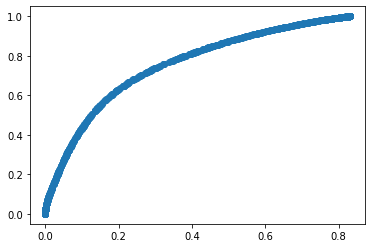

  39: TIME: 2.47 ETA: 150.43 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.39244219 0.40411227]]

0.2860948592179262 0.7097388728823169 [-0.29993687] [-0.22480685]

[[0.21950159 0.41062198]]

0.27021224607390176 0.90527464416878 [-0.58067007] [-0.08744331]

[[0.11173645 0.34409887]]

0.2804269808320607 0.9830208609383327 [-0.76085384] [0.01947028]

[[0.09050208 0.29481542]]

0.31120733439296605 0.9520808557913055 [-0.80686651] [0.07758084]

[[0.08139024 0.26874956]]

0.3292007575882818 0.9095409265730932 [-0.82425683] [0.10620269]

[[0.07783682 0.25969604]]

0.33422905770727973 0.891489600832159 [-0.83107618] [0.11490207]

[[0.07662502 0.25771963]]

0.33460216917956515 0.8853997348593984 [-0.83359311] [0.11614588]

[[0.07609499 0.25761722]]

0.333891396044193 0.882780463086289 [-0.83483206] [0.11555464]

[[0.0757662  0.25790533]]

0.33304920061773297 0.881171641089606 [-0.835664] [0.11466646]

[[0.07551701 0.25823437]]

0.33228442528476604 0.879953335488016 [-0.83

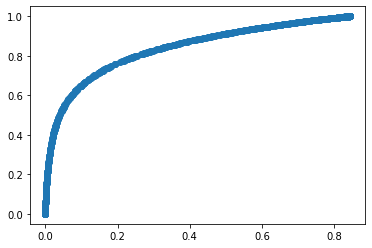

  40: TIME: 2.26 ETA: 135.64 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.45700954 0.48017661]]

0.28427974404944995 0.7151699439236727 [-0.40060773] [-0.2967845]

[[0.24830271 0.48083581]]

0.26752154745828843 0.9174400426650583 [-0.71068321] [-0.14590778]

[[0.12446339 0.39702406]]

0.28262120715670835 0.9801535331369582 [-0.9010601] [-0.02839524]

[[0.09922978 0.33418678]]

0.31771903134160034 0.9329413834324871 [-0.949465] [0.03895532]

[[0.0893243  0.30403422]]

0.3348591124672019 0.8907192701825628 [-0.96651025] [0.06852967]

[[0.08682019 0.29579694]]

0.3393678440241605 0.8794711782576574 [-0.97065215] [0.0763675]

[[0.08639972 0.29402958]]

0.34046854452026254 0.8775534389776787 [-0.97127496] [0.07818114]

[[0.08638336 0.2935919 ]]

0.3408550789899922 0.8774541766771206 [-0.97123502] [0.07874432]

[[0.08643043 0.29342058]]

0.341076231714361 0.8776440237973129 [-0.97110149] [0.07903468]

[[0.08647987 0.29331456]]

0.34123962227040483 0.8778481562204398 [-

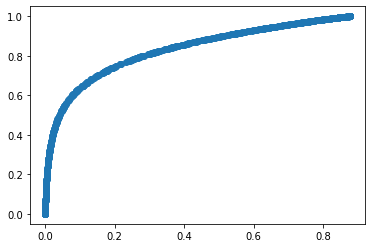

  41: TIME: 2.08 ETA: 122.50 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.50599908 0.5281137 ]]

0.28430903848705563 0.7169742959866001 [-0.41460733] [-0.31701668]

[[0.27391203 0.53144657]]

0.2680201420043241 0.9150815069536616 [-0.74363231] [-0.15679788]

[[0.13394983 0.43800297]]

0.2851791228650954 0.9796777311780468 [-0.94630515] [-0.02913759]

[[0.10751159 0.36834151]]

0.32117749434618964 0.9338300897070535 [-0.99537202] [0.04257221]

[[0.09804202 0.3360103 ]]

0.3386979725415866 0.896563768021948 [-1.01083881] [0.0737531]

[[0.09601194 0.32675226]]

0.34413472275782797 0.8880178161287873 [-1.01370686] [0.08306473]

[[0.09597133 0.32422468]]

0.3462224053992853 0.8876566705853689 [-1.01338963] [0.08624079]

[[0.09627145 0.32318309]]

0.3474669237663362 0.888712156334527 [-1.01259115] [0.08795275]

[[0.0965831  0.32251939]]

0.3484059294343281 0.8898354247526491 [-1.01183017] [0.08919661]

[[0.09685331 0.32200711]]

0.34916640478183314 0.8908091387316384 [

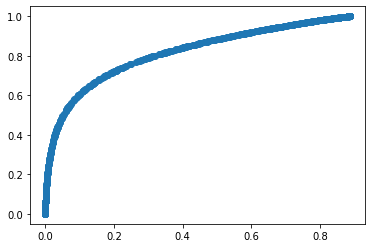

  42: TIME: 3.82 ETA: 221.37 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.54405784 0.56409037]]

0.2873382137813771 0.7196600175355949 [-0.39926201] [-0.30001786]

[[0.29026129 0.57057618]]

0.2712399630852002 0.9159665720208406 [-0.73959934] [-0.13202604]

[[0.14056952 0.46862319]]

0.29023549619293776 0.9798690419654597 [-0.94829288] [0.00347026]

[[0.11449686 0.39529153]]

0.3258962462008255 0.9378707794539918 [-0.99590659] [0.07685671]

[[0.10596936 0.36236063]]

0.3434048737452242 0.9061868836458321 [-1.00922929] [0.10863868]

[[0.1044484  0.35227825]]

0.3496748841330493 0.8998535547026368 [-1.01090957] [0.11929958]

[[0.10477883 0.34898048]]

0.35267301412900215 0.9006692932014908 [-1.00974701] [0.12381225]

[[0.10540115 0.34731417]]

0.3547199705612292 0.9026355157758778 [-1.00823353] [0.12666677]

[[0.10599453 0.3461318 ]]

0.3563492755841843 0.9045290031427964 [-1.00685374] [0.12888278]

[[0.10650917 0.34517926]]

0.35770384071178823 0.906161500654182 [

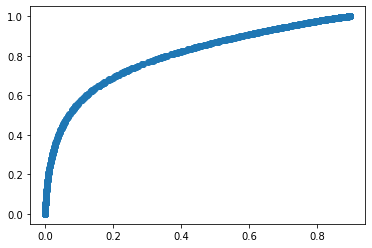

  43: TIME: 2.43 ETA: 138.62 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.54644068 0.56720429]]

0.2837921932856393 0.7133930824107253 [-0.34275429] [-0.24009636]

[[0.27693346 0.57639974]]

0.26900512029823026 0.9164886077156229 [-0.6896658] [-0.07010567]

[[0.13721778 0.47438955]]

0.2931731769922622 0.979209863277193 [-0.88769582] [0.06574864]

[[0.11586313 0.40660527]]

0.32823228370327734 0.9451654987774886 [-0.92840272] [0.13572233]

[[0.10965413 0.37617597]]

0.3462464793513407 0.9217916250824428 [-0.93800464] [0.16730126]

[[0.10898821 0.3653005 ]]

0.35423802056398684 0.9181599270561924 [-0.9380185] [0.18020427]

[[0.10986774 0.3608473 ]]

0.3589054731356792 0.9204424730941849 [-0.93563331] [0.18698169]

[[0.11097748 0.35821965]]

0.36238947225252366 0.9236366699332595 [-0.93302247] [0.19175891]

[[0.11201013 0.3562344 ]]

0.36526080741933575 0.926602104071243 [-0.93065879] [0.1956226]

[[0.1129141  0.35458932]]

0.3676982220346421 0.9291571518645043 [-0

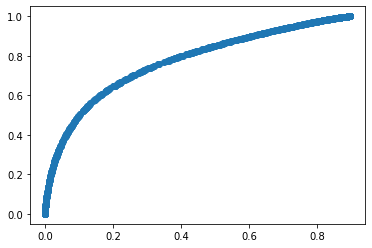

  44: TIME: 3.03 ETA: 169.48 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.56338044 0.58338695]]

0.28739735430577723 0.7078152254519002 [-0.2367768] [-0.14272882]

[[0.27250287 0.60012954]]

0.2742414568016645 0.9133677796634487 [-0.59278308] [0.03543044]

[[0.13393358 0.49263853]]

0.3056705925250537 0.9792361229899632 [-0.78637179] [0.18191605]

[[0.11818304 0.42845588]]

0.34057213016900123 0.9565427725406728 [-0.81834716] [0.25053262]

[[0.11590692 0.40125786]]

0.35996824834764046 0.9463689008044283 [-0.82103776] [0.28286603]

[[0.11730018 0.38933055]]

0.37147962915489363 0.9482480850773308 [-0.81694957] [0.30023803]

[[0.11941615 0.38251475]]

0.3798388878180404 0.952747931452713 [-0.81182046] [0.31208765]

[[0.12140918 0.37753917]]

0.38654502801850593 0.9569409527368341 [-0.80713641] [0.32139467]

[[0.12311627 0.37350809]]

0.3920910858346502 0.9603445111371465 [-0.80314297] [0.32906568]

[[0.12454538 0.37014578]]

0.39671234855068227 0.9630339037409038 

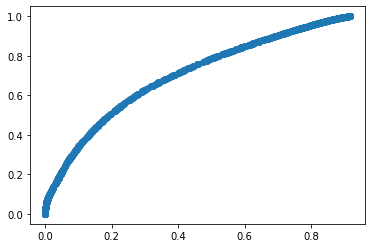

  45: TIME: 3.04 ETA: 167.40 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.55971436 0.58752038]]

0.286639904975191 0.7211937226358982 [-0.12113678] [-0.02632873]

[[0.24614209 0.60550229]]

0.2765002158359739 0.9242661533151049 [-0.49215845] [0.16222123]

[[0.12671914 0.49583458]]

0.3185606553833952 0.9786141801411691 [-0.6640809] [0.3124195]

[[0.11738635 0.43801966]]

0.35499902523670473 0.9640187839050333 [-0.68468595] [0.37942234]

[[0.11830983 0.41319259]]

0.3771599181917198 0.9624527987768149 [-0.68120865] [0.41416374]

[[0.12114729 0.3995794 ]]

0.39269454930487047 0.9666073497689351 [-0.67388445] [0.43690552]

[[0.12393856 0.38988499]]

0.40481908080597806 0.9707836830193375 [-0.6668962] [0.45433451]

[[0.12632711 0.38211359]]

0.4146561098113617 0.9740471761237736 [-0.66091813] [0.46851005]

[[0.12832715 0.37566468]]

0.4227616934990837 0.9765290116184967 [-0.65588569] [0.48027023]

[[0.13000559 0.37025793]]

0.429501852225692 0.9784432577093134 [-0.65

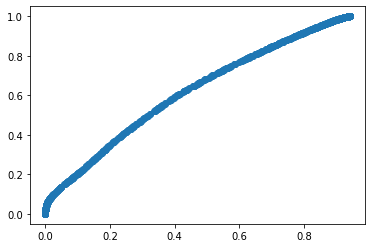

  46: TIME: 3.55 ETA: 191.69 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.63017239 0.65675892]]

0.2844554907503424 0.7234801041863128 [0.03940969] [0.13940254]

[[0.24175865 0.68257749]]

0.27812147312849667 0.9296634840365396 [-0.37131826] [0.3504629]

[[0.12127704 0.54709635]]

0.34126744498640277 0.9715977815796016 [-0.53480376] [0.53227329]

[[0.1178063  0.48032076]]

0.3853933041380902 0.962427559292068 [-0.54268888] [0.61297806]

[[0.12193071 0.44828859]]

0.4139185904496803 0.966857015294681 [-0.53184435] [0.66038316]

[[0.12637417 0.42559934]]

0.435554637124386 0.9721507612708841 [-0.52037734] [0.69620098]

[[0.13022681 0.40696889]]

0.4529635359934175 0.976110164425261 [-0.51034539] [0.72557283]

[[0.13354681 0.39120484]]

0.4673424104173489 0.9790597673444053 [-0.50163553] [0.75028043]

[[0.1364472  0.37775446]]

0.47941430528539 0.9813426864880481 [-0.49401376] [0.771329]

[[0.13900398 0.36622414]]

0.48965877024109866 0.983161986587106 [-0.48731287]

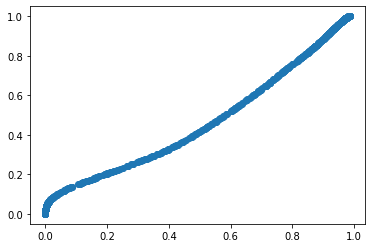

  47: TIME: 4.64 ETA: 246.08 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.72752154 0.75387854]]

0.288287603000889 0.7036265582284179 [0.19389238] [0.30280374]

[[0.26657454 0.78810132]]

0.28214625486176775 0.9236561931079478 [-0.24852818] [0.53357149]

[[0.12233177 0.61299397]]

0.35984587821050046 0.964620194182564 [-0.42365974] [0.75710469]

[[0.12181018 0.52666536]]

0.4102598759897942 0.958765145182129 [-0.4241846] [0.85662479]

[[0.12790159 0.48014878]]

0.4435485379376472 0.965837282690026 [-0.4085828] [0.91934532]

[[0.13368392 0.44405832]]

0.46905351531316297 0.9718193433991512 [-0.39377818] [0.96858097]

[[0.13875299 0.41423438]]

0.48943508083742726 0.9760481301252056 [-0.38079329] [1.00897491]

[[0.14323724 0.38967365]]

0.5059424972348809 0.9791453445586988 [-0.36947357] [1.04230489]

[[0.14719603 0.3696647 ]]

0.5193257986895156 0.9814971183811328 [-0.3597247] [1.06967466]

[[0.15064377 0.35355203]]

0.5301172403416684 0.9833189159236632 [-0.35147

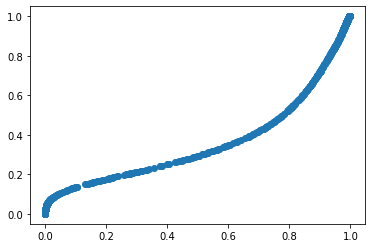

  48: TIME: 2.26 ETA: 117.51 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.80767581 0.84620267]]

0.2838910010033323 0.713083418621487 [0.2553101] [0.38220864]

[[0.27526602 0.87687829]]

0.2801145027791594 0.9325208285948603 [-0.22476368] [0.63205802]

[[0.13135659 0.6753345 ]]

0.3636955358695579 0.9609425629119177 [-0.39504009] [0.8700121]

[[0.13206933 0.57813868]]

0.41490839201232127 0.9564445882948897 [-0.39240285] [0.97667386]

[[0.13924235 0.52396538]]

0.4487851550768728 0.9643753136463915 [-0.37489677] [1.04502733]

[[0.14593429 0.48159549]]

0.47470729156283453 0.9707178101403225 [-0.35860784] [1.09878208]

[[0.15182    0.44692798]]

0.4952872012422908 0.9751591090524628 [-0.34437338] [1.14255598]

[[0.1570153  0.41886823]]

0.5117495755614632 0.9783683159435946 [-0.33208623] [1.17816979]

[[0.16155087 0.3965236 ]]

0.5248525729337918 0.980757924186257 [-0.32168941] [1.20683069]

[[0.16542562 0.37900926]]

0.5351729141212717 0.9825678007059458 [-0.3130

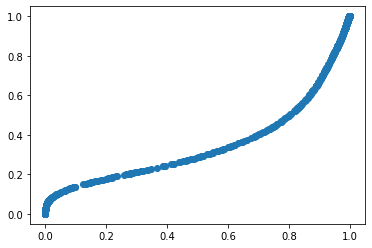

  49: TIME: 1.53 ETA: 78.08 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.85844604 0.90712483]]

0.282880220160833 0.713184238432148 [0.15949134] [0.29049572]

[[0.31038937 0.93594743]]

0.2778828060327656 0.9313815507338393 [-0.33004427] [0.54267275]

[[0.15409391 0.7353446 ]]

0.3495575013289296 0.9662197807944385 [-0.51308693] [0.76790581]

[[0.15134672 0.6404383 ]]

0.3952667164847569 0.9580358853383442 [-0.51761822] [0.86599596]

[[0.1579208  0.59432844]]

0.4245914618642986 0.9642090653366713 [-0.50272134] [0.92414367]

[[0.1644962  0.56028582]]

0.44706247135220517 0.9702004268447965 [-0.48804361] [0.96899221]

[[0.17016938 0.53191653]]

0.46524043252773906 0.9744801091961659 [-0.47528803] [1.00608816]

[[0.17510386 0.50787043]]

0.48028639954213953 0.9776151719261568 [-0.46417435] [1.03737249]

[[0.17945726 0.48742261]]

0.49290918983189597 0.980022288889302 [-0.45442444] [1.06399619]

[[0.18332162 0.47001038]]

0.5035821689436706 0.9819332980668655 [-0.44

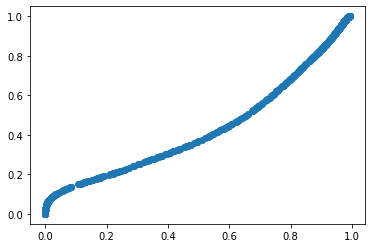

  50: TIME: 2.85 ETA: 142.48 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.98556644 1.04448541]]

0.28459338090321595 0.7221162864661397 [-0.13997445] [0.00593989]

[[0.42141689 1.06276855]]

0.27381322057427687 0.9298971877454316 [-0.64311063] [0.25963795]

[[0.20135488 0.84384257]]

0.32195554282700306 0.9697189398163879 [-0.87835582] [0.47342718]

[[0.18005533 0.72609985]]

0.359563890413067 0.9405955544183271 [-0.90969529] [0.56798166]

[[0.18012823 0.68394127]]

0.3777083169912184 0.9369941784627763 [-0.90707092] [0.60782034]

[[0.18444371 0.66489321]]

0.38910623596048993 0.9424735524021108 [-0.89881419] [0.63069529]

[[0.18883158 0.65207585]]

0.3978822929215731 0.9481795804892544 [-0.89087783] [0.64779648]

[[0.19259275 0.64186127]]

0.4050374737528635 0.9527618676529235 [-0.88412758] [0.66169928]

[[0.19572476 0.63340188]]

0.4109442363835115 0.9563115732901725 [-0.87850174] [0.67320814]

[[0.19832367 0.62635475]]

0.4158353725795062 0.9590689870031899 [-

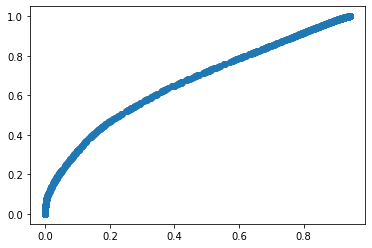

  51: TIME: 2.59 ETA: 126.88 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.37804429 1.43542191]]

0.28647347810511314 0.7119645471004955 [-0.53984282] [-0.38737824]

[[0.7122552  1.44770548]]

0.2701452731299474 0.9143896166757203 [-1.10097822] [-0.11179568]

[[0.29618828 1.14693496]]

0.304936079618465 0.9675487446236681 [-1.44592411] [0.14344162]

[[0.24266456 0.93278674]]

0.34950362695365544 0.9137490560332435 [-1.50686148] [0.27869646]

[[0.23905136 0.85816813]]

0.3697571318183531 0.9053003236902143 [-1.5062919] [0.33245975]

[[0.24544364 0.82799285]]

0.38163429383204617 0.9126280068823949 [-1.49508101] [0.36097968]

[[0.25208646 0.8081038 ]]

0.3905834024641553 0.9202146180122741 [-1.48445426] [0.38185721]

[[0.25774753 0.79264167]]

0.39773507800983265 0.9263249096519028 [-1.47556036] [0.39846779]

[[0.26244876 0.78024992]]

0.40351786528663686 0.9311296818576131 [-1.46823275] [0.41188978]

[[0.26633449 0.77025662]]

0.40821006339056165 0.9349187948950355

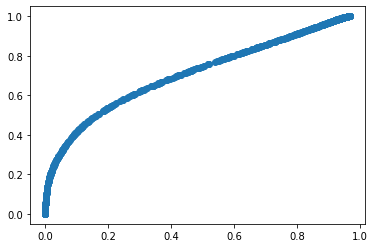

  52: TIME: 2.86 ETA: 137.26 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.70762875 1.76432569]]

0.2870955305073193 0.7029203636479228 [-0.74206179] [-0.56801529]

[[0.92378588 1.77510826]]

0.26946447898056347 0.9084894667066248 [-1.34992725] [-0.27122563]

[[0.37433285 1.40706272]]

0.30067262398163586 0.9671704118606799 [-1.75172041] [0.01294702]

[[0.30095375 1.1230325 ]]

0.3481520228547149 0.9086451352009741 [-1.82530525] [0.17295488]

[[0.29666385 1.02196663]]

0.37041372286024477 0.9002896127257499 [-1.82309736] [0.2383101]

[[0.3061736  0.98014064]]

0.3837691741094246 0.9093098642460963 [-1.80802215] [0.27386786]

[[0.31591283 0.95182147]]

0.3939876754430063 0.918296855161818 [-1.79390371] [0.30038409]

[[0.32427675 0.92963321]]

0.4022188859448064 0.9255110198379473 [-1.78202062] [0.3216487]

[[0.33129302 0.91182968]]

0.40890878915275597 0.9311907502809801 [-1.77215945] [0.338903]

[[0.33714018 0.89748066]]

0.4143559492029715 0.9356707584106655 [-1.

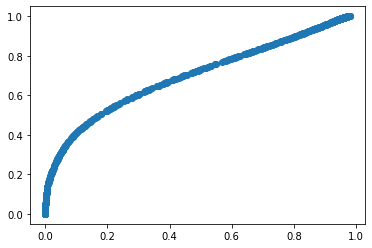

  53: TIME: 2.61 ETA: 122.55 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.68419581 1.73299934]]

0.2849059979756568 0.721843873059982 [-0.60100936] [-0.44226728]

[[0.88459974 1.74960718]]

0.26842300100665106 0.9156603626198113 [-1.21945228] [-0.14079497]

[[0.37082903 1.39389439]]

0.30086323554124533 0.9693423466189669 [-1.60441765] [0.13536552]

[[0.30231441 1.12937108]]

0.3463089406795895 0.9153071833864861 [-1.67496062] [0.28721882]

[[0.29616816 1.03276911]]

0.3675485570625809 0.9046767666249106 [-1.67571279] [0.34942377]

[[0.30407137 0.99452705]]

0.37985662267158166 0.9120786024152595 [-1.66296995] [0.38189417]

[[0.31276429 0.96962902]]

0.38920871782187894 0.9202631591499868 [-1.65041454] [0.40574052]

[[0.32034848 0.95005379]]

0.39681448199525937 0.9269921525165654 [-1.63968061] [0.42501665]

[[0.32676348 0.93410641]]

0.4030787582309955 0.9323531543289323 [-1.63067527] [0.44087132]

[[0.33215681 0.92103186]]

0.40825260357932436 0.936627525862942

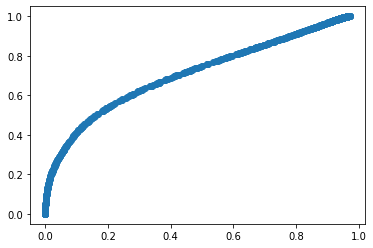

  54: TIME: 1.50 ETA: 69.13 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.44339983 1.49901006]]

0.28584938416831934 0.7014122044021234 [-0.27125097] [-0.13097789]

[[0.71393449 1.53228282]]

0.27149952233573216 0.908501055482508 [-0.8495556] [0.15430694]

[[0.31288146 1.2319207 ]]

0.3099644043982516 0.9718694972443781 [-1.18140029] [0.41422777]

[[0.27261928 1.03836175]]

0.3519047378465386 0.9392138990630016 [-1.23052072] [0.5420374]

[[0.27133921 0.96180037]]

0.37403198989325326 0.9335197045960678 [-1.22788985] [0.60049764]

[[0.27871448 0.92601576]]

0.3882636875226732 0.9400424224301845 [-1.21556384] [0.63492879]

[[0.28661348 0.90158886]]

0.3993760343621799 0.9471414674885192 [-1.2033031] [0.66103676]

[[0.29354153 0.88193343]]

0.4085469247593502 0.952889504542532 [-1.19266491] [0.6825231]

[[0.2994194  0.86554143]]

0.4162018283166031 0.9573555441757614 [-1.18364281] [0.70050264]

[[0.30438026 0.85180959]]

0.42260446811658453 0.9608297472158751 [-1.176

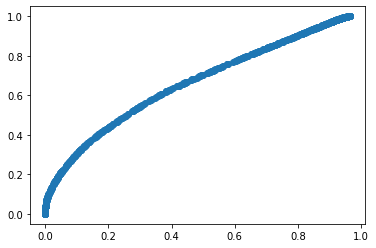

  55: TIME: 2.77 ETA: 124.85 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.27970142 1.35173725]]

0.2857039443421691 0.7157076432077359 [0.03731784] [0.19785489]

[[0.52034918 1.38616642]]

0.276401980658196 0.9282940022102157 [-0.54125963] [0.49281617]

[[0.25156898 1.10139605]]

0.33388678936141475 0.9691026597964217 [-0.79147546] [0.74902517]

[[0.23856746 0.95400013]]

0.3770826716772913 0.9538873883179324 [-0.80971316] [0.86506158]

[[0.24573068 0.88794614]]

0.40375999377578564 0.9579409333878327 [-0.79592947] [0.92913344]

[[0.25487417 0.84468865]]

0.42366931417192927 0.9646106681528323 [-0.77971934] [0.97580604]

[[0.2629733  0.81025359]]

0.4396434301565239 0.9697550684322344 [-0.76541576] [1.01356113]

[[0.26989831 0.78167055]]

0.45275219347676104 0.9735149227289728 [-0.75314794] [1.04491337]

[[0.2758516  0.75776455]]

0.4636343613400019 0.9763373148699644 [-0.74260584] [1.07119239]

[[0.28100058 0.73770293]]

0.47273897385754854 0.9785206931245403 [-

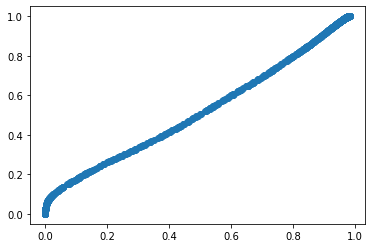

  56: TIME: 2.47 ETA: 108.82 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.19766146 1.27143043]]

0.2865331840092456 0.7127197904767485 [0.30994462] [0.45899333]

[[0.43450706 1.31276427]]

0.28118076738087255 0.9305926058564428 [-0.26935735] [0.76108712]

[[0.20890284 1.02590604]]

0.3558327612437437 0.9648772904834213 [-0.48684101] [1.03719574]

[[0.20684205 0.88498105]]

0.40439206684401835 0.9576828924841642 [-0.48967309] [1.16110587]

[[0.21645164 0.81089422]]

0.43605436662465086 0.9645360621643921 [-0.47101603] [1.23769502]

[[0.22578457 0.75540318]]

0.4600170821915308 0.9706521857815844 [-0.45301207] [1.2965635]

[[0.2338857  0.71046895]]

0.4789738659913839 0.9749617273413149 [-0.43737155] [1.34413293]

[[0.24094054 0.6739088 ]]

0.49421793848288265 0.9780802378710401 [-0.42389083] [1.38297745]

[[0.24708999 0.64425433]]

0.5065557755649054 0.9804255309838421 [-0.41235224] [1.41475046]

[[0.25241271 0.62028128]]

0.5165555933314534 0.9822352360496789 [-0

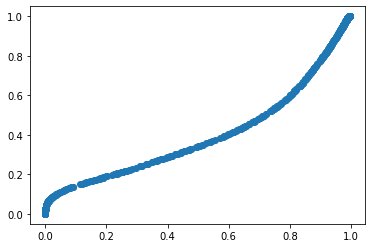

  57: TIME: 1.74 ETA: 74.73 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.16563925 1.23143301]]

0.28207710185149737 0.7093407726135251 [0.42460507] [0.56219348]

[[0.40285699 1.27776114]]

0.27878717609432246 0.929223836659584 [-0.1566474] [0.86238935]

[[0.19313316 0.99673714]]

0.3617712346237692 0.9630379840144987 [-0.36175786] [1.14585795]

[[0.1940656  0.85545837]]

0.41366628647403875 0.9585336224576537 [-0.36006321] [1.27574417]

[[0.20396034 0.77583082]]

0.4475941979486989 0.9659420283544288 [-0.34041226] [1.35853766]

[[0.2131745  0.71528804]]

0.47296183618656235 0.9718979759591664 [-0.3220384] [1.42201685]

[[0.22119003 0.6671121 ]]

0.49267755679234587 0.9760231409612046 [-0.30613715] [1.47247311]

[[0.22816759 0.62897196]]

0.5081796214833589 0.9789802139528501 [-0.29257784] [1.51272252]

[[0.23418129 0.59904162]]

0.5203793900252572 0.9811735945102777 [-0.28121388] [1.54468834]

[[0.23927296 0.57573301]]

0.5299445686783038 0.9828335337710091 [-0.2

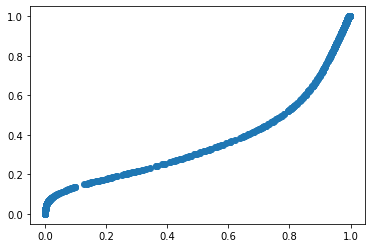

  58: TIME: 3.51 ETA: 147.60 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.0739168  1.13418481]]

0.285624561821797 0.7180458935964305 [0.37245938] [0.51255904]

[[0.36378678 1.18110996]]

0.2837838277030779 0.9341655926283938 [-0.17938579] [0.80437734]

[[0.18850008 0.93633736]]

0.36320917400815367 0.9685955551522463 [-0.36302658] [1.06379614]

[[0.19017109 0.81449946]]

0.4143685870650441 0.9656542746496583 [-0.36078946] [1.18506052]

[[0.19887934 0.74201879]]

0.4488585540607051 0.9715928980062715 [-0.34285417] [1.26528215]

[[0.20695441 0.68551505]]

0.47490143427145054 0.9764203877928086 [-0.32589286] [1.32774368]

[[0.21407504 0.63957547]]

0.495406609913579 0.9798799101149883 [-0.31090356] [1.37824771]

[[0.22041226 0.6022976 ]]

0.5118292276717336 0.9824701744577096 [-0.29778522] [1.41942684]

[[0.22602667 0.57225295]]

0.5250432208098548 0.984472045002633 [-0.28646846] [1.45296047]

[[0.23092655 0.54821396]]

0.5356550716986566 0.9860382527093761 [-0.276

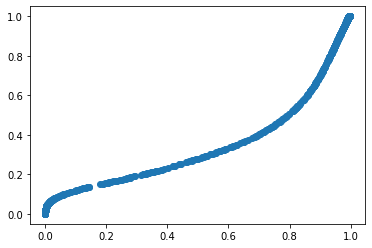

  59: TIME: 2.27 ETA: 92.88 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.94811068 0.99556106]]

0.2856380245538536 0.7037194308488314 [0.24218989] [0.36748935]

[[0.35530678 1.0425721 ]]

0.2811674151954029 0.9239720762187722 [-0.2555311] [0.62646703]

[[0.19237127 0.85542155]]

0.34575337052403493 0.9765648804161763 [-0.43833341] [0.84374064]

[[0.19127166 0.76188914]]

0.3928979601577737 0.9730045519375407 [-0.44260008] [0.94554082]

[[0.19794382 0.70827913]]

0.4257648850674812 0.9768683675301416 [-0.42856139] [1.01285816]

[[0.20451673 0.66658753]]

0.4510670523438802 0.9808506164902792 [-0.41429449] [1.06588614]

[[0.21029023 0.63135912]]

0.4715352169281899 0.9838840577404733 [-0.40145807] [1.11008695]

[[0.21541096 0.60107997]]

0.48856803230949297 0.9861989944447311 [-0.3899314] [1.14777611]

[[0.22001913 0.57493937]]

0.5029806589504756 0.9880055573474665 [-0.37954698] [1.18027399]

[[0.22419221 0.55235641]]

0.5152847710591288 0.9894341410915389 [-0.370

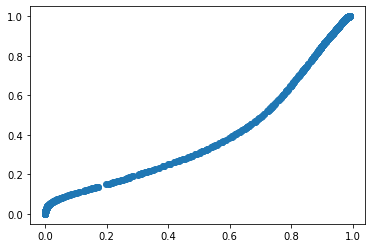

learning rate changed!


  60: TIME: 3.41 ETA: 136.23 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.85869537 0.90554041]]

0.2857168522640662 0.7059923781097538 [0.13665158] [0.2505116]

[[0.35423537 0.94411942]]

0.2787433359489685 0.9201933421686808 [-0.32573916] [0.48785835]

[[0.19706065 0.78903955]]

0.3285253901102619 0.9814449638243685 [-0.51214281] [0.67353072]

[[0.19225904 0.71220803]]

0.36946434162569325 0.9772098097128167 [-0.52412704] [0.75829003]

[[0.19683382 0.67181338]]

0.39842769632778857 0.9791338248971349 [-0.51432675] [0.81217071]

[[0.20214814 0.64271053]]

0.42066942201016455 0.9825365407898651 [-0.50276798] [0.85339907]

[[0.20686186 0.61877359]]

0.43861771203227673 0.9853233799495199 [-0.492295] [0.88732154]

[[0.21091615 0.59830434]]

0.45349622015338215 0.987407451562698 [-0.48308991] [0.91603973]

[[0.21443162 0.58059351]]

0.46604834122138183 0.9889737778692163 [-0.4749757] [0.94070472]

[[0.21751488 0.56518746]]

0.4767690964817674 0.9901745948038493 [-0.4

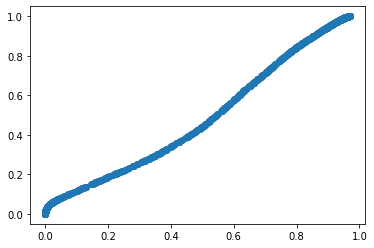

  61: TIME: 1.80 ETA: 70.02 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.79652116 0.81842007]]

0.2872905949684721 0.716867965100135 [0.047967] [0.16424909]

[[0.34855582 0.85612262]]

0.2779480463464229 0.9212254436069486 [-0.37789097] [0.38192418]

[[0.19689476 0.72226172]]

0.31581657450620665 0.9843976712826148 [-0.56636238] [0.54473791]

[[0.18883652 0.65528734]]

0.35132667004337265 0.9800635077946668 [-0.58510356] [0.61757814]

[[0.1914136  0.62189096]]

0.37696809691686456 0.9801185852138704 [-0.57918793] [0.66243318]

[[0.19552297 0.5996374 ]]

0.39650377669964454 0.9827967670594816 [-0.57001103] [0.69555829]

[[0.199392   0.58225815]]

0.41215901203393496 0.9853875322737112 [-0.56130855] [0.72219373]

[[0.20272439 0.56778486]]

0.42503292837108825 0.987387380982813 [-0.55368371] [0.74438407]

[[0.2055599  0.55547435]]

0.4357803083805362 0.9888789825471 [-0.54708338] [0.76316148]

[[0.20798534 0.54492382]]

0.44484693785619367 0.990003528214539 [-0.5413

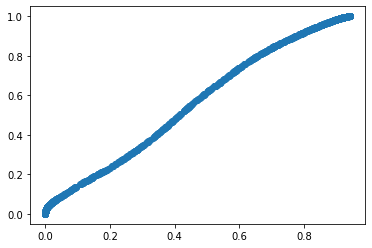

  62: TIME: 4.01 ETA: 152.50 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.71326332 0.74765369]]

0.2885735446064638 0.7156329637777614 [-0.04493019] [0.06563316]

[[0.34610111 0.77031646]]

0.27646210966748574 0.9177407230947666 [-0.43975991] [0.26554203]

[[0.197582  0.6545022]]

0.3011591467881844 0.98610577930679 [-0.63315016] [0.40771275]

[[0.18489714 0.59380059]]

0.330763674737663 0.9817744977628166 [-0.66103279] [0.47078237]

[[0.18490681 0.56433115]]

0.35300314586987913 0.9792311059059626 [-0.66008101] [0.50845748]

[[0.18750467 0.54630123]]

0.3696273578661426 0.9806783845919744 [-0.65385249] [0.53484049]

[[0.19047466 0.53345948]]

0.3827168512950007 0.9830909952835057 [-0.64702267] [0.55513351]

[[0.19317834 0.52337622]]

0.3933510023018527 0.9852407379144429 [-0.64081705] [0.57156099]

[[0.19549167 0.51508954]]

0.40212252185567166 0.9869192243804514 [-0.63545905] [0.58517034]

[[0.19744086 0.50816053]]

0.40941706511344833 0.9881938444163658 [-0.63

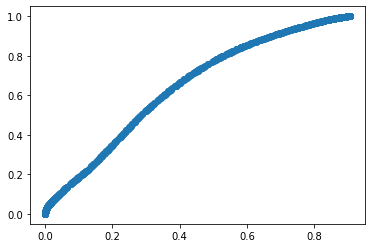

  63: TIME: 1.48 ETA: 54.76 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.6898647  0.70826059]]

0.28642751184065374 0.7117020578271973 [-0.11573441] [-0.00486282]

[[0.35471382 0.72887362]]

0.27237599356255326 0.912116025163419 [-0.49044742] [0.18104539]

[[0.20036447 0.62168479]]

0.28938001951866776 0.9861276113410622 [-0.6932574] [0.31457875]

[[0.183132   0.56042311]]

0.316674308174345 0.9809552358592075 [-0.72926819] [0.37575975]

[[0.18086898 0.52974865]]

0.33795979839686563 0.975385904593312 [-0.73237307] [0.41226501]

[[0.1822381  0.51172718]]

0.3534168639690901 0.9753069365319673 [-0.7283365] [0.43670591]

[[0.18466514 0.49995158]]

0.3652547078499775 0.9776360357207844 [-0.72254476] [0.45457339]

[[0.18715779 0.49133918]]

0.3747496150831193 0.9802596454148962 [-0.71683201] [0.46857892]

[[0.18938447 0.48453286]]

0.3825441965924662 0.9825000122088644 [-0.71176328] [0.47999409]

[[0.19128149 0.47894851]]

0.38900690652161735 0.9842661173830174 [-0.7

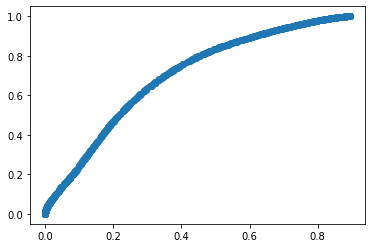

  64: TIME: 3.21 ETA: 115.59 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65457838 0.6907301 ]]

0.282547430277591 0.718127783286391 [-0.18044059] [-0.05809242]

[[0.34500633 0.69754668]]

0.2675631301186062 0.9190514314568645 [-0.55141524] [0.12282971]

[[0.19977681 0.59485764]]

0.281516869487768 0.9860098728055413 [-0.74885703] [0.24642498]

[[0.18046346 0.53403997]]

0.308351979779159 0.9786335593045149 [-0.78766016] [0.30658309]

[[0.17639434 0.50143646]]

0.3296820582724055 0.9696154246979408 [-0.7935708] [0.34352524]

[[0.17663127 0.48242312]]

0.3446451884698871 0.9676361620232299 [-0.79132381] [0.36751222]

[[0.17856686 0.47081903]]

0.35569473022080317 0.9697275805512359 [-0.7863368] [0.38417986]

[[0.18092926 0.46291889]]

0.3644131608516018 0.9728906687565871 [-0.78087666] [0.39679836]

[[0.18318042 0.45693259]]

0.37156227473391656 0.9758742338731227 [-0.77582197] [0.40694227]

[[0.18515323 0.45209756]]

0.37752112808109534 0.9783487053987453 [-0.771

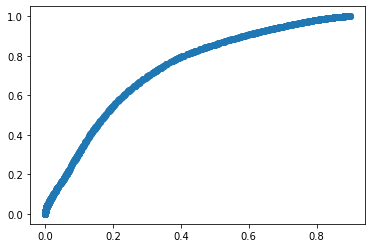

  65: TIME: 2.49 ETA: 87.14 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65502416 0.68024833]]

0.2888169755701732 0.7140508092108268 [-0.20405434] [-0.10180587]

[[0.36946661 0.68996674]]

0.27265986449365087 0.9080804067254781 [-0.56287883] [0.07571942]

[[0.20411948 0.58788793]]

0.2813188205681001 0.9861327684222685 [-0.77947325] [0.20460334]

[[0.1799675 0.5215982]]

0.30737641200232635 0.978514272583827 [-0.82635562] [0.26777655]

[[0.17411971 0.48600753]]

0.3289779705320512 0.9664734693647182 [-0.83495399] [0.30629701]

[[0.17339728 0.46571775]]

0.34370247671538245 0.9624540780630974 [-0.8340937] [0.33048777]

[[0.17491835 0.45401551]]

0.35418621907938264 0.9639756929075073 [-0.82973213] [0.34653468]

[[0.17715159 0.44649033]]

0.36231697351215947 0.9673004220871824 [-0.82449922] [0.35831848]

[[0.17939826 0.44096753]]

0.36898008797955417 0.9706914929979605 [-0.81948889] [0.36769979]

[[0.18141631 0.43654716]]

0.374572857729602 0.9736115757813744 [-0.

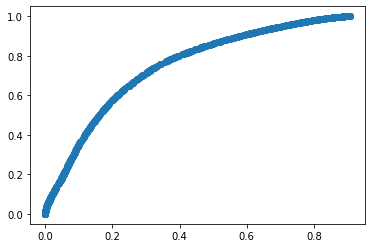

  66: TIME: 2.33 ETA: 79.25 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.66395437 0.69467248]]

0.28622421796970116 0.7233623326783906 [-0.24734026] [-0.13542782]

[[0.37672672 0.69762674]]

0.2694322473352186 0.9148248954740341 [-0.61314631] [0.04356136]

[[0.20810793 0.59184111]]

0.2778317694273077 0.9857112083883683 [-0.83232356] [0.17163006]

[[0.18108272 0.52005006]]

0.3056903445076282 0.9738596644532421 [-0.88192693] [0.23874332]

[[0.17296803 0.47931657]]

0.3282104348044123 0.9561002176759796 [-0.89323754] [0.28021309]

[[0.17102037 0.45708306]]

0.3423826939890308 0.9492446090705849 [-0.89397092] [0.30457836]

[[0.17212367 0.44552053]]

0.35172945780577275 0.9502724902675199 [-0.89027277] [0.3193869]

[[0.1743014 0.4387264]]

0.35876237252677856 0.9540761896609764 [-0.88526461] [0.3297503]

[[0.17663899 0.43392329]]

0.36456467796213815 0.9582551821356967 [-0.88026207] [0.3379655]

[[0.17881246 0.43006593]]

0.3695447549609415 0.9620203499051556 [-0.87

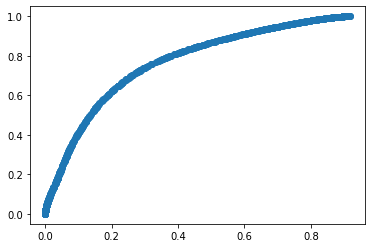

  67: TIME: 2.25 ETA: 74.25 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65935447 0.68139227]]

0.28374344287590875 0.7083810406728758 [-0.25743675] [-0.15334973]

[[0.38207715 0.68690624]]

0.26686039636856546 0.9043284102550044 [-0.61644551] [0.0197383]

[[0.20712803 0.58473328]]

0.27396431192705945 0.9846816427739403 [-0.84213605] [0.14850412]

[[0.17871138 0.51188756]]

0.30255528446617297 0.9726979611197357 [-0.89444375] [0.21713003]

[[0.16992327 0.46957106]]

0.32608818319643545 0.9532382045705402 [-0.90684196] [0.26019034]

[[0.16759105 0.44637292]]

0.34077562338876255 0.9453547752638014 [-0.90806882] [0.28539727]

[[0.16857816 0.43451304]]

0.3502986890026135 0.9462362700494018 [-0.90445791] [0.30045516]

[[0.17076737 0.42768248]]

0.35740579765974007 0.9502809603908231 [-0.89936102] [0.31087076]

[[0.17316439 0.42289502]]

0.36327937039713715 0.9548089796889986 [-0.89420416] [0.31912136]

[[0.17541474 0.41904425]]

0.36835094413878544 0.95892806876940

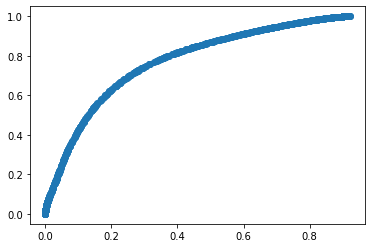

  68: TIME: 2.47 ETA: 79.07 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.66735858 0.6910885 ]]

0.28480288515039687 0.7187671455365661 [-0.25747448] [-0.15974116]

[[0.38936363 0.6954415 ]]

0.2679682295022145 0.9073565578130548 [-0.62235554] [0.01708709]

[[0.20883179 0.5906221 ]]

0.27515975839472323 0.9848983231276619 [-0.85212382] [0.14844207]

[[0.17931848 0.51469763]]

0.30442613400828306 0.9714856686730253 [-0.90556217] [0.21917319]

[[0.17007439 0.47073307]]

0.3281532139750291 0.9507823037813765 [-0.91832964] [0.26314938]

[[0.16772189 0.44728201]]

0.34264546961084774 0.9428376551855832 [-0.91944885] [0.28829401]

[[0.16882449 0.43559417]]

0.35194991699218037 0.9440079861616884 [-0.91563599] [0.30309836]

[[0.17111694 0.42888587]]

0.3589217883997478 0.9482879199788681 [-0.91038944] [0.31336969]

[[0.17359065 0.42412693]]

0.3647275569576005 0.952971342732917 [-0.90512527] [0.32158306]

[[0.17590299 0.4202513 ]]

0.3697718819601681 0.957202627839066 [-

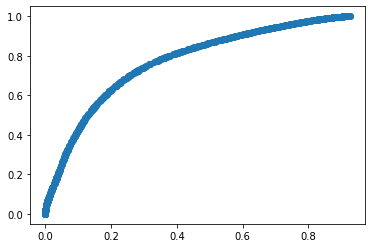

  69: TIME: 3.75 ETA: 116.12 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.6754793  0.69829758]]

0.28764377483164527 0.7164760216070593 [-0.27004803] [-0.16005746]

[[0.39305363 0.70221881]]

0.270181536109052 0.9091119035476664 [-0.63169701] [0.01694303]

[[0.21088941 0.594342  ]]

0.27712514098634117 0.9849525283911079 [-0.86212853] [0.14943986]

[[0.18068869 0.51624427]]

0.30652509800276234 0.9705866698338319 [-0.91592819] [0.22123534]

[[0.17116361 0.47131061]]

0.3301507506626426 0.9492120968820971 [-0.92876015] [0.26552169]

[[0.16884515 0.44787042]]

0.34438072539354936 0.9413815487471435 [-0.92968463] [0.29041252]

[[0.17005452 0.43638408]]

0.3534799283517461 0.9428005768101358 [-0.92568246] [0.3049517]

[[0.17243035 0.42978155]]

0.3603347936750982 0.947238273452425 [-0.92031474] [0.3150911]

[[0.17496369 0.42504383]]

0.3660797622132265 0.9520097579761746 [-0.91496837] [0.32326474]

[[0.177324  0.4211488]]

0.3710940147434816 0.9562986553663788 [-0.91

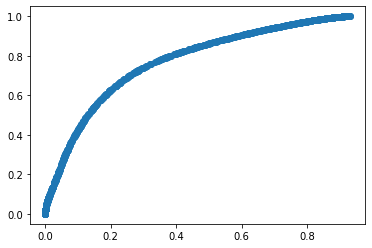

  70: TIME: 2.17 ETA: 65.21 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.67285771 0.69647574]]

0.28604160065846596 0.7133211946475013 [-0.26665701] [-0.16066747]

[[0.3945611  0.69980736]]

0.2686609667301844 0.9064614628670411 [-0.62861467] [0.01519338]

[[0.21087745 0.59314765]]

0.2754565133232077 0.9846057288081298 [-0.86057709] [0.14760351]

[[0.18042043 0.51481108]]

0.3052296928958189 0.9702127553086932 [-0.91495703] [0.21989319]

[[0.17074009 0.4692566 ]]

0.32928833498860005 0.9484697365276984 [-0.92803488] [0.26484631]

[[0.16835286 0.44538818]]

0.3437943450587136 0.9404478753298778 [-0.92900698] [0.2901765]

[[0.16957997 0.43371203]]

0.3530549335150252 0.9419222389802945 [-0.92492198] [0.30494947]

[[0.17201231 0.42701684]]

0.3600329679905114 0.9465154190223425 [-0.91942057] [0.31524766]

[[0.1746127  0.42221048]]

0.36589370629090046 0.9514557757250567 [-0.91392836] [0.32356416]

[[0.17703967 0.41825011]]

0.37102201279522956 0.9558971421239983 [-

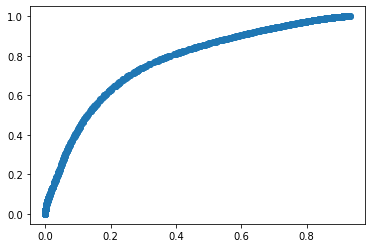

  71: TIME: 1.90 ETA: 55.09 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.66493615 0.68930179]]

0.2865069729448299 0.7186789120286067 [-0.2636919] [-0.14622171]

[[0.37908727 0.69251055]]

0.2691071730289489 0.9132436467207332 [-0.6250294] [0.03020419]

[[0.20640396 0.58607739]]

0.2777331945902601 0.9850205427915947 [-0.847023] [0.15991061]

[[0.17921046 0.5117    ]]

0.3072623524275391 0.9715613756248225 [-0.8967258] [0.22960681]

[[0.17122481 0.46906141]]

0.33100658911571257 0.953424298227248 [-0.90742755] [0.27304733]

[[0.16987936 0.44612465]]

0.3461051707090688 0.9478456461993432 [-0.90679938] [0.29866974]

[[0.17164221 0.4340785 ]]

0.3563939929916798 0.9502744822121645 [-0.90169437] [0.31469114]

[[0.1743616  0.42665101]]

0.3644009883486538 0.955083556612946 [-0.89549833] [0.32636909]

[[0.17712154 0.42112639]]

0.3711364014089213 0.9599001762434959 [-0.88952308] [0.3358925]

[[0.1796297  0.41656104]]

0.3769592006924031 0.9640565204165983 [-0.8841553]

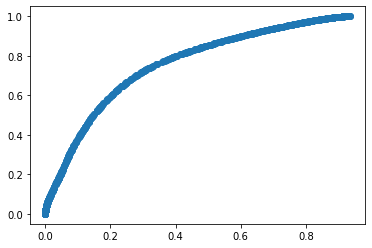

  72: TIME: 2.41 ETA: 67.39 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.67188252 0.69232079]]

0.28906435814282416 0.7033373327293785 [-0.2438391] [-0.1337221]

[[0.38944176 0.69959537]]

0.2716349500142989 0.9029631724494341 [-0.59992275] [0.04127076]

[[0.20730723 0.59278248]]

0.2796270367177343 0.9845572935944056 [-0.82953767] [0.17587023]

[[0.17987964 0.51716392]]

0.309003294369504 0.9726828607451663 [-0.88030091] [0.24645249]

[[0.17260472 0.47492925]]

0.33285520381303774 0.9565554118573018 [-0.89006617] [0.29000132]

[[0.17185522 0.45203166]]

0.3484703452526742 0.9523077009282988 [-0.88848668] [0.31624674]

[[0.17396824 0.43953864]]

0.3594701938328223 0.9552216282276226 [-0.88271299] [0.33326352]

[[0.17688279 0.43151072]]

0.36816878571159095 0.9600441125660824 [-0.87606175] [0.34596566]

[[0.17975173 0.42541097]]

0.37549119151569754 0.9646646444354943 [-0.86977407] [0.35638742]

[[0.18231965 0.42035401]]

0.38178361805361927 0.9685496373654411 [-0

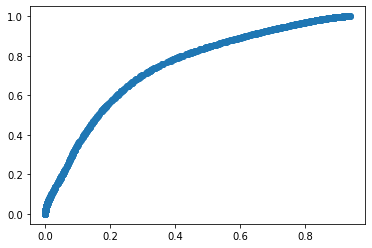

  73: TIME: 2.37 ETA: 63.89 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65996631 0.68593061]]

0.28657154660111733 0.7178536949968337 [-0.22915909] [-0.12402959]

[[0.37700322 0.69095458]]

0.2697175801797379 0.9101184807939692 [-0.59225966] [0.05348388]

[[0.20408834 0.58628982]]

0.2792315915426868 0.9851107617223781 [-0.81397494] [0.18465252]

[[0.17911976 0.51453098]]

0.3085505788093728 0.9741171921366193 [-0.8613728] [0.25298114]

[[0.17284832 0.4742862 ]]

0.3324561661381306 0.9600675197448278 [-0.86981603] [0.29570591]

[[0.17255656 0.45177347]]

0.34864844671505524 0.9568114265904504 [-0.86754799] [0.32237357]

[[0.17483491 0.43892051]]

0.3603832371093285 0.959882393762152 [-0.86139865] [0.34027601]

[[0.17780123 0.43039455]]

0.3697498283692943 0.9645435511494864 [-0.85450849] [0.35385056]

[[0.18067777 0.42385075]]

0.3776181814070164 0.9689076216800413 [-0.84805753] [0.36500035]

[[0.18323306 0.41843622]]

0.3843411974108836 0.9725219622094488 [-0.8

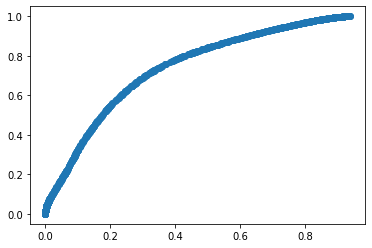

  74: TIME: 4.15 ETA: 107.85 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65882353 0.68310938]]

0.2861193943781368 0.7125881635121158 [-0.21022512] [-0.10161565]

[[0.36934099 0.69036798]]

0.26950133614828614 0.9093453217070118 [-0.57286263] [0.07556933]

[[0.2005154 0.5860419]]

0.28093838569758695 0.9848606163318561 [-0.79021555] [0.20710559]

[[0.17805286 0.51668715]]

0.3106126604169679 0.9749702550837106 [-0.83414788] [0.27436712]

[[0.17319943 0.47838325]]

0.3346717786000907 0.9637529222258693 [-0.84052387] [0.31648487]

[[0.17374682 0.45642273]]

0.3516031360702171 0.9622359548398274 [-0.83689953] [0.34376464]

[[0.17639588 0.44310351]]

0.3643484838323188 0.9657047725438637 [-0.82999389] [0.36297126]

[[0.17949338 0.43377733]]

0.3746840641976186 0.9701260929179555 [-0.82267986] [0.37794401]

[[0.18240223 0.42643846]]

0.38337171449479734 0.9740548513857941 [-0.81596556] [0.39033732]

[[0.18495387 0.42033791]]

0.3907594032919666 0.9772215184530882 [-0

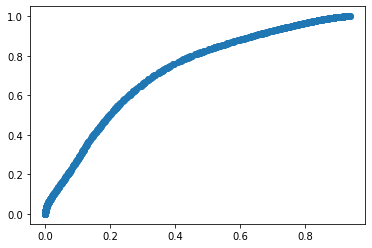

  75: TIME: 1.99 ETA: 49.70 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65054004 0.67397076]]

0.2858646877063296 0.71998819839914 [-0.19699242] [-0.08472138]

[[0.35769815 0.68144687]]

0.26946837765819376 0.9145091026401224 [-0.55973315] [0.09288195]

[[0.19717986 0.57861656]]

0.2821085724796881 0.9852809319888653 [-0.76968993] [0.22186422]

[[0.17673349 0.51236555]]

0.31165505088183254 0.9761524521285597 [-0.81066849] [0.28724884]

[[0.17272397 0.47587692]]

0.33568487657846524 0.9665745021897614 [-0.81580787] [0.32851722]

[[0.17364242 0.45448471]]

0.3530112616999936 0.9657845555568929 [-0.81157754] [0.35593793]

[[0.17638372 0.44103063]]

0.3663052096393842 0.9692409004262966 [-0.80442408] [0.37574212]

[[0.17946152 0.43135724]]

0.37716180831648305 0.973380122242807 [-0.79701] [0.39138258]

[[0.18231972 0.42366338]]

0.3862920607396612 0.9769853211610885 [-0.79024426] [0.40437623]

[[0.18481918 0.41725511]]

0.39404567797939954 0.9798608312256106 [-0.78

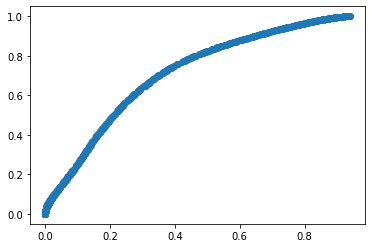

  76: TIME: 2.11 ETA: 50.76 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.65369569 0.66980431]]

0.28510443433231203 0.717194339382929 [-0.1621393] [-0.06422228]

[[0.35844094 0.68260634]]

0.26938166837198807 0.9090799883760586 [-0.52644012] [0.11367599]

[[0.19412667 0.58137532]]

0.2835100142289108 0.985024435665852 [-0.73870802] [0.24598203]

[[0.17542628 0.51640098]]

0.3137994036432497 0.9773886116494055 [-0.77775423] [0.31155252]

[[0.17260329 0.48115755]]

0.3385055441589452 0.9700846837275454 [-0.78115095] [0.35308276]

[[0.1741616  0.45984142]]

0.3568992558627265 0.9704096135202771 [-0.77581295] [0.3816815]

[[0.17713853 0.44563903]]

0.37138640689063507 0.9739015318485731 [-0.76808297] [0.40314671]

[[0.18026907 0.43495881]]

0.38334954038678576 0.9776512035009847 [-0.76034251] [0.42047901]

[[0.18312461 0.42628033]]

0.3934418693430107 0.980798253353546 [-0.75333359] [0.43501332]

[[0.18561669 0.41899429]]

0.4020228035595529 0.9832674307511371 [-0.74

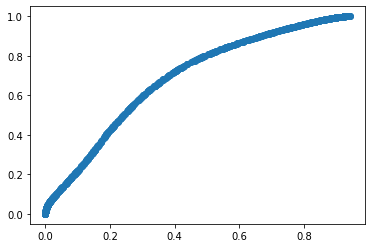

  77: TIME: 2.36 ETA: 54.17 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.64657055 0.66800923]]

0.28600771403957437 0.720203935103198 [-0.14450596] [-0.04231928]

[[0.34592132 0.68052997]]

0.27066064252601696 0.9133714190743608 [-0.51079698] [0.13789994]

[[0.18994808 0.57917193]]

0.287354649911407 0.9852580058873038 [-0.71465454] [0.26975078]

[[0.17397883 0.51711838]]

0.31804520108915735 0.9785295826584115 [-0.74929437] [0.33400471]

[[0.17234315 0.48379149]]

0.3429582338922625 0.9732497830329532 [-0.75070763] [0.37498979]

[[0.17441732 0.46300441]]

0.36197988626760674 0.9743892982929805 [-0.74443549] [0.40411858]

[[0.1775166  0.44842877]]

0.37726539657495295 0.9777443146287669 [-0.73636077] [0.42668924]

[[0.18061846 0.43704937]]

0.39000951079432694 0.9810562816615903 [-0.72848953] [0.44526327]

[[0.18341526 0.42762524]]

0.40081297441508007 0.9837611208000338 [-0.7213856] [0.46099514]

[[0.18586072 0.41963719]]

0.4100360586039947 0.9858636008983926 [

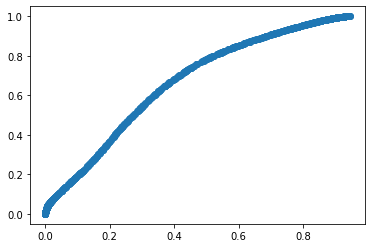

  78: TIME: 3.75 ETA: 82.40 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.63782776 0.65810312]]

0.28647917481134066 0.7171847409760598 [-0.12901773] [-0.0286229]

[[0.3406496  0.67185522]]

0.2712459399249701 0.9116680607213137 [-0.49162124] [0.15011569]

[[0.18728557 0.57273335]]

0.28829221425364465 0.9853504846967172 [-0.69313818] [0.28138816]

[[0.17242911 0.51271126]]

0.31896027660810433 0.9796437634211299 [-0.72638776] [0.34462169]

[[0.17126175 0.48056996]]

0.34408504667232875 0.9752548609268882 [-0.72709989] [0.38525615]

[[0.17346392 0.46009114]]

0.3635481150808683 0.9765701267980363 [-0.72057929] [0.41466908]

[[0.17653374 0.44536792]]

0.37933076129256105 0.9797449313029434 [-0.71246215] [0.43779965]

[[0.17956424 0.43369029]]

0.3925498684145963 0.9828052390759868 [-0.70459102] [0.45699638]

[[0.18229374 0.42393983]]

0.40379020953250516 0.985284737283362 [-0.69747002] [0.47333894]

[[0.18468852 0.41563433]]

0.41341486581793463 0.9872066292920674 

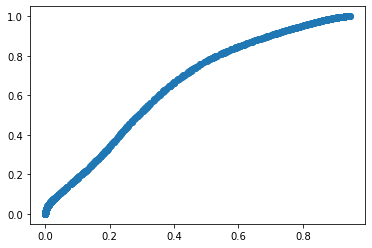

  79: TIME: 2.11 ETA: 44.35 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.63559844 0.66363293]]

0.28807774987722823 0.7164481673729232 [-0.11840149] [-0.01061651]

[[0.33467945 0.67541572]]

0.27285889010614517 0.9147271068913913 [-0.48260167] [0.17042486]

[[0.18576364 0.57445592]]

0.29163961395828103 0.9853422205067469 [-0.67913399] [0.30222817]

[[0.17230041 0.51506936]]

0.32286494711347197 0.9797754347583529 [-0.70972779] [0.36550101]

[[0.17173401 0.48327894]]

0.34833465568589095 0.9762628775740323 [-0.70922496] [0.40645245]

[[0.17423394 0.46264449]]

0.3682957811042943 0.9779768482160325 [-0.70203982] [0.43660272]

[[0.177426   0.44739599]]

0.38465074629984347 0.9811383337512032 [-0.69355426] [0.4607198]

[[0.18051154 0.43505113]]

0.3984440329812334 0.9840533363304242 [-0.68541922] [0.48097313]

[[0.18328362 0.42461652]]

0.41023746578325937 0.9863827502899947 [-0.67804901] [0.49835857]

[[0.18572735 0.41565532]]

0.42039083086510753 0.988183396495428

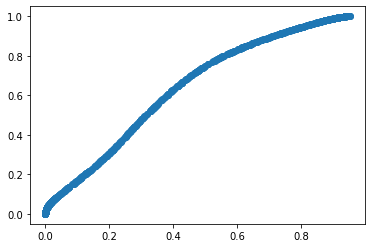

  80: TIME: 3.43 ETA: 68.55 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.63531307 0.66356949]]

0.2856238428172454 0.7224146685472651 [-0.11695919] [-0.00193901]

[[0.32557932 0.67470175]]

0.27084426604761985 0.9201398054815911 [-0.48496633] [0.17999169]

[[0.18471551 0.57431124]]

0.29145364148917513 0.9853577056974283 [-0.67380589] [0.3091257]

[[0.17257242 0.51667157]]

0.3231449850563908 0.9799052945886673 [-0.70194485] [0.37167839]

[[0.17238631 0.48532039]]

0.3489387414571223 0.9769438203059897 [-0.70074296] [0.41275489]

[[0.17502461 0.46458039]]

0.3693051214804645 0.9788344493483977 [-0.69326304] [0.4434021]

[[0.17826086 0.44899464]]

0.3860843655739797 0.9819580865692327 [-0.68461784] [0.46815481]

[[0.18136457 0.43624485]]

0.40028734490005463 0.9847846376836153 [-0.67634991] [0.48906993]

[[0.18415455 0.42540122]]

0.4124698495222632 0.9870315476268635 [-0.66883758] [0.50710493]

[[0.18662305 0.4160463 ]]

0.42299321990684563 0.9887672868009059 [-0

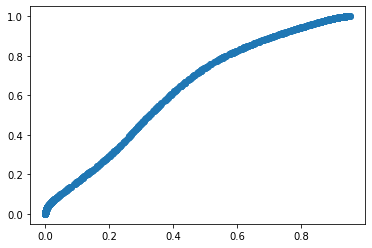

  81: TIME: 3.14 ETA: 59.63 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.66257452 0.67911654]]

0.285024088788657 0.7228939911399852 [-0.10019458] [-0.00266261]

[[0.34921696 0.69494578]]

0.2701240729697583 0.9132946447388766 [-0.47373504] [0.18069932]

[[0.18997458 0.5918637 ]]

0.2897828862293928 0.9848707378930898 [-0.67773277] [0.31664381]

[[0.17610916 0.52926511]]

0.3224597061757211 0.9787786982395299 [-0.70902354] [0.38291196]

[[0.17566824 0.4953041 ]]

0.3490399190196546 0.9753077072175778 [-0.70815383] [0.42615533]

[[0.178448   0.47308819]]

0.36995445242991176 0.977323585669552 [-0.70028277] [0.45821384]

[[0.18193694 0.45649969]]

0.38719624190105323 0.9807372781418019 [-0.6910635] [0.48407266]

[[0.18530285 0.44293221]]

0.4018296674889531 0.9838305678390551 [-0.68221282] [0.505968]

[[0.18833902 0.43136819]]

0.4144218450225047 0.9862913764971669 [-0.67414901] [0.52490837]

[[0.19103399 0.4213655 ]]

0.4253347882095854 0.9881942021847254 [-0.6669

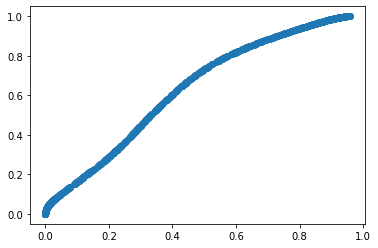

  82: TIME: 2.24 ETA: 40.39 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.67239    0.70023551]]

0.28904251100367157 0.7088622596443952 [-0.11366357] [-0.0017058]

[[0.35827957 0.71250617]]

0.27326039983431055 0.9109636541753623 [-0.48476467] [0.18277078]

[[0.19444784 0.60411966]]

0.2923028735885526 0.9844785722541142 [-0.69184901] [0.32170257]

[[0.17983247 0.53850148]]

0.32488432746889867 0.9779126227014765 [-0.72379188] [0.38940862]

[[0.17932605 0.5031954 ]]

0.3513351389284143 0.9743214771056129 [-0.72278009] [0.43331187]

[[0.18225056 0.48032786]]

0.3721319075544332 0.9764902131401216 [-0.71455302] [0.46572724]

[[0.18592275 0.46330342]]

0.3893068205019495 0.9800656271973819 [-0.70497278] [0.49188193]

[[0.18946336 0.44936854]]

0.40391598702045123 0.9832843704434314 [-0.69579676] [0.51406772]

[[0.19265922 0.43747701]]

0.4165127527115222 0.9858431610180718 [-0.68743999] [0.53329383]

[[0.19549949 0.42718094]]

0.4274488502783771 0.9878247133730869 [-

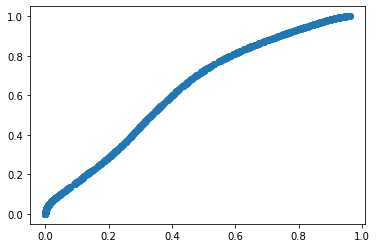

  83: TIME: 3.11 ETA: 52.81 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.6996215 0.7248809]]

0.28428666679906006 0.7085586991584136 [-0.11929845] [-0.00418744]

[[0.36899794 0.73720461]]

0.268709357988146 0.9112862358043328 [-0.50134295] [0.18227797]

[[0.20011829 0.6251762 ]]

0.28896226310445533 0.9836304278224453 [-0.71155289] [0.32288987]

[[0.18482342 0.55617237]]

0.3226819430785177 0.9759613025423696 [-0.74407346] [0.39314718]

[[0.18418665 0.51838593]]

0.34970795801932897 0.9720229369635264 [-0.7431325] [0.4388777]

[[0.18730977 0.49411324]]

0.3707984072231788 0.9744448342403685 [-0.73450679] [0.47239766]

[[0.19128488 0.47621338]]

0.38817415717243403 0.9783950594675703 [-0.72438903] [0.4993205]

[[0.19512883 0.46162183]]

0.4029533231729974 0.9819396564904151 [-0.71468927] [0.5221277]

[[0.19860046 0.44918626]]

0.41570365963019906 0.9847542789619276 [-0.70585912] [0.54189086]

[[0.20168566 0.43842449]]

0.4267795353550247 0.986933605735338 [-0.6979

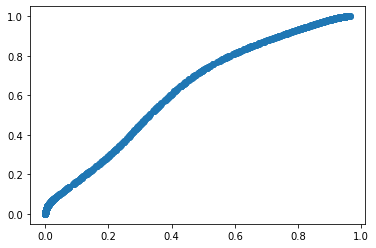

  84: TIME: 2.82 ETA: 45.20 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.7267839  0.75081145]]

0.2872626022792606 0.7222024510233419 [-0.12092799] [-0.01394669]

[[0.38938022 0.7636524 ]]

0.2715399566036824 0.9140492473096924 [-0.5113708] [0.17881988]

[[0.20748429 0.64579487]]

0.29080237534349107 0.9841199230147543 [-0.73101029] [0.32459914]

[[0.1904047  0.57174645]]

0.32453835968230543 0.9754359354941047 [-0.7658817] [0.39748985]

[[0.1894362  0.53167703]]

0.3514891202129041 0.9709142927916234 [-0.765254] [0.4443815]

[[0.19266312 0.50639996]]

0.3724090417041357 0.9733486366214202 [-0.7563891] [0.47839262]

[[0.19685201 0.48794647]]

0.3896270027778047 0.9774567738586903 [-0.74592806] [0.50560209]

[[0.20091255 0.47294628]]

0.40428122188329707 0.9811495481735452 [-0.73590687] [0.52864035]

[[0.20458087 0.46017034]]

0.4169330213966203 0.9840838400725856 [-0.72679519] [0.54860795]

[[0.207841   0.44911762]]

0.4279288531890634 0.9863592998779673 [-0.7186

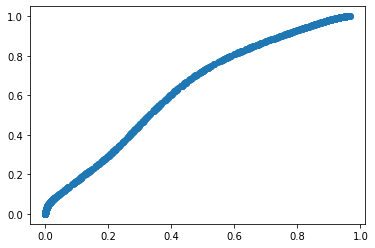

  85: TIME: 2.68 ETA: 40.15 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.75190146 0.78492977]]

0.28560083687158416 0.7030061046319841 [-0.14501849] [-0.02837153]

[[0.41180257 0.79387151]]

0.26921401830729436 0.90697318550796 [-0.53815205] [0.16344463]

[[0.21816464 0.67120587]]

0.28687243201806534 0.9831228343795788 [-0.76692732] [0.31152828]

[[0.19830998 0.59162968]]

0.3206291696023838 0.9733984392439774 [-0.8055129] [0.38701457]

[[0.19638061 0.54821368]]

0.34745927694208006 0.9674617683631938 [-0.80627867] [0.43524284]

[[0.19947426 0.52169547]]

0.3678665328549537 0.9697130614333243 [-0.7976942] [0.46928952]

[[0.20388215 0.50307863]]

0.38446093107587054 0.9742457566750305 [-0.78706183] [0.49594402]

[[0.20823347 0.48828223]]

0.3985108710659303 0.9784364970651429 [-0.77680054] [0.51825942]

[[0.2121646  0.47581496]]

0.410598105443488 0.9817858745721791 [-0.76750718] [0.53747249]

[[0.21563789 0.46510331]]

0.4210623388488645 0.9843821098330486 [-0.7

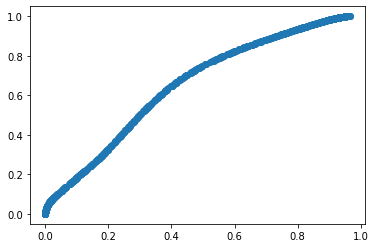

  86: TIME: 3.52 ETA: 49.27 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.7993877  0.82951172]]

0.28829317011081446 0.7105233648642547 [-0.16335587] [-0.04316577]

[[0.44398597 0.83812647]]

0.2713381825947413 0.9093258090144185 [-0.56536086] [0.15472017]

[[0.23126664 0.70528835]]

0.2875475185834384 0.9831762887314209 [-0.8072146] [0.30919071]

[[0.20755158 0.61611898]]

0.32162630351965477 0.9709878169217859 [-0.85015029] [0.38942742]

[[0.2045248  0.56781369]]

0.3483410528291128 0.963258159682611 [-0.85203455] [0.43977545]

[[0.20764889 0.53959575]]

0.36818088094328594 0.965472630478581 [-0.84328738] [0.47417064]

[[0.2124579  0.52049798]]

0.3841592941364088 0.9705600400742617 [-0.83214132] [0.50060549]

[[0.21724952 0.50553747]]

0.39766769802298957 0.9753095526559862 [-0.82137969] [0.52260796]

[[0.22157286 0.49299097]]

0.4092855326621812 0.9791062139743476 [-0.81167768] [0.54150742]

[[0.22537942 0.48224417]]

0.4193319857913645 0.9820499385976091 [-0.

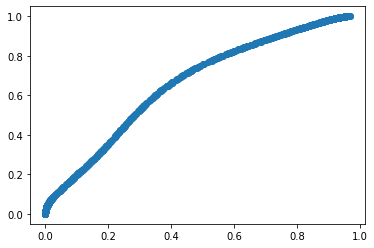

  87: TIME: 3.21 ETA: 41.67 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.83156609 0.86172562]]

0.28581217800530745 0.7214749348834394 [-0.18139343] [-0.05813536]

[[0.4611574  0.86770296]]

0.26884066631231984 0.9144058356075394 [-0.59605554] [0.14421335]

[[0.24162927 0.72961129]]

0.28476778467328756 0.9831847437953859 [-0.84198801] [0.29917647]

[[0.21550477 0.63511864]]

0.31926590297058705 0.969094257483075 [-0.8872654] [0.3819512]

[[0.21138897 0.58300455]]

0.3460844968205123 0.9596282472495008 [-0.89038718] [0.43395667]

[[0.21432688 0.55332907]]

0.3655695159248558 0.961559288887132 [-0.88186975] [0.46862496]

[[0.21936561 0.53393901]]

0.3810756829353748 0.9670871104364067 [-0.87049894] [0.49474892]

[[0.22447848 0.51902324]]

0.39414941878647913 0.97237971763152 [-0.85942852] [0.51632519]

[[0.22909951 0.50659199]]

0.40538713463524934 0.9766310968093639 [-0.84946091] [0.53480415]

[[0.23315517 0.49597739]]

0.4150925207587324 0.9799247055324714 [-0.8

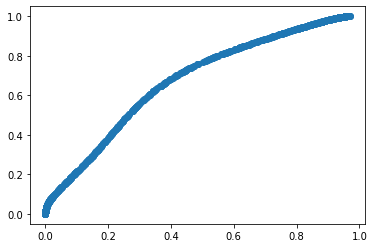

  88: TIME: 3.18 ETA: 38.10 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.88615924 0.90817145]]

0.28746791933639526 0.7124235702705888 [-0.18471159] [-0.05490153]

[[0.49154671 0.91877099]]

0.2702026108230554 0.9102037706160859 [-0.60531217] [0.15119147]

[[0.25238185 0.77056793]]

0.2865022257825274 0.9824889726127044 [-0.86292297] [0.31465229]

[[0.22445012 0.66779495]]

0.32186575337508483 0.967507431757475 [-0.90977834] [0.40196502]

[[0.22045378 0.61197631]]

0.3490151320574045 0.9583343740116597 [-0.91227352] [0.45618108]

[[0.22397703 0.58048879]]

0.36875426312433535 0.9608954894302416 [-0.90274357] [0.49228659]

[[0.22957379 0.55967216]]

0.38456825420623314 0.9667527467595195 [-0.89051404] [0.51974928]

[[0.23514998 0.54342952]]

0.3979643689469217 0.9721689498143429 [-0.87874232] [0.54261025]

[[0.2401697  0.52979054]]

0.4095114035517281 0.9764710104443219 [-0.86816408] [0.56227661]

[[0.24458217 0.51810336]]

0.4195068425876454 0.9797980774678228 [-

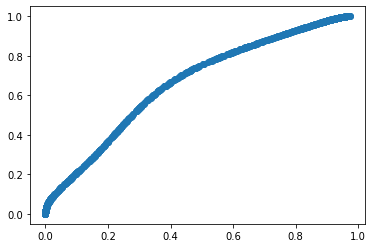

  89: TIME: 2.18 ETA: 23.97 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.89374274 0.93155119]]

0.28500027928272964 0.7068392702311895 [-0.16673098] [-0.04687071]

[[0.50014238 0.9389749 ]]

0.2682113568070685 0.9062399787081379 [-0.59708327] [0.16199424]

[[0.25617361 0.79009295]]

0.28551805831096266 0.9820740951892267 [-0.85683686] [0.32752797]

[[0.22942733 0.68735626]]

0.3213553742702169 0.9684246729818616 [-0.90241757] [0.41536815]

[[0.22622052 0.63107905]]

0.34915658360092283 0.9606084831482296 [-0.90388357] [0.47074335]

[[0.23013094 0.59821493]]

0.3698049389811185 0.9634920250219966 [-0.89371054] [0.50866734]

[[0.23591861 0.57576984]]

0.3865214765753152 0.9691729275114047 [-0.88102577] [0.53803551]

[[0.24163086 0.55800115]]

0.4007198187840107 0.974327783757738 [-0.86884653] [0.56264756]

[[0.24678093 0.5430115 ]]

0.41297177215016373 0.9784052077054796 [-0.85786283] [0.58388302]

[[0.25132823 0.53013609]]

0.42359458382581283 0.9815563554812876 [

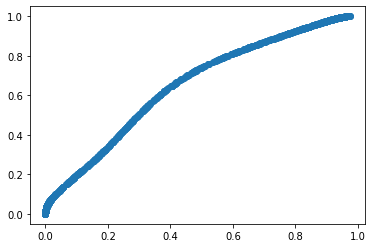

  90: TIME: 2.60 ETA: 26.03 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.91452024 0.94006855]]

0.2823226222126543 0.7053384320874059 [-0.13558574] [-0.0247075]

[[0.50721004 0.95407378]]

0.2661459670079465 0.9026635916604406 [-0.57149493] [0.1847603]

[[0.25790822 0.80605581]]

0.28474299369620926 0.9817837936807787 [-0.83355367] [0.3526575]

[[0.23280954 0.70401146]]

0.32130252252756814 0.9695925887606627 [-0.87746403] [0.44108912]

[[0.23059632 0.64762174]]

0.34997301921407986 0.9632877114866478 [-0.8776442] [0.49777071]

[[0.23493234 0.61334934]]

0.3717594463618851 0.9664952706748379 [-0.86673535] [0.53782312]

[[0.24087866 0.58903156]]

0.3896075361215425 0.9719296415686866 [-0.85356846] [0.56949687]

[[0.24668702 0.56942296]]

0.40483168800045427 0.976753941131238 [-0.8409471] [0.59629078]

[[0.25194116 0.55275593]]

0.4180070038520517 0.9805551526531504 [-0.82949504] [0.61953369]

[[0.25661358 0.53836894]]

0.4294710000274776 0.9834938687059607 [-0.819

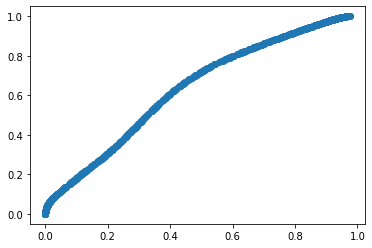

  91: TIME: 2.21 ETA: 19.85 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.90725334 0.93403546]]

0.28565981002079066 0.7141440165389933 [-0.11338178] [0.00306682]

[[0.49331273 0.9492782 ]]

0.2695733187900045 0.9090501544976924 [-0.54809076] [0.21550086]

[[0.25539879 0.80150732]]

0.2893292927971576 0.9827749754569126 [-0.80072277] [0.38203381]

[[0.23354498 0.70438473]]

0.3253431039504399 0.9724461834942516 [-0.8402888] [0.46779258]

[[0.232595   0.65083518]]

0.3540749227877602 0.9679384497977546 [-0.83866688] [0.52365591]

[[0.23717441 0.61674158]]

0.3765385620927729 0.9711827272057985 [-0.82728498] [0.56461364]

[[0.24296157 0.59142734]]

0.39521394171769614 0.9759836295942349 [-0.81410778] [0.59783003]

[[0.24855368 0.57055525]]

0.41124533415084324 0.9801688439662452 [-0.80149478] [0.62627401]

[[0.25363822 0.55263098]]

0.4251853936286675 0.9834662880476546 [-0.78995628] [0.65113784]

[[0.25820148 0.53704567]]

0.43737727292416495 0.9860217590209381 [-0

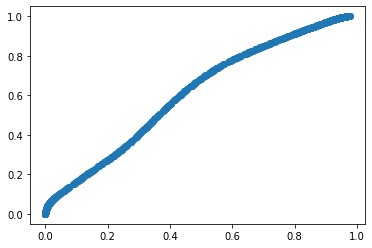

  92: TIME: 3.24 ETA: 25.89 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.9185131  0.95477482]]

0.28656147942962507 0.7170328989706164 [-0.09139246] [0.04346857]

[[0.47985922 0.96826359]]

0.2706826540219983 0.9164164923350103 [-0.53351736] [0.2613693]

[[0.25489104 0.8149367 ]]

0.29406820082536883 0.9826085629905581 [-0.77404126] [0.42841713]

[[0.23660325 0.71958095]]

0.33084328266811075 0.9730202417634195 [-0.80779503] [0.51402949]

[[0.23716445 0.66660301]]

0.3601542169923302 0.9703453908189072 [-0.8036582] [0.57080981]

[[0.24235773 0.6313117 ]]

0.3835811032899425 0.973998411090528 [-0.79109867] [0.6138791]

[[0.24835878 0.60386099]]

0.4033454913418887 0.9785194412131836 [-0.77726734] [0.64973648]

[[0.25407776 0.5806193 ]]

0.42047150755345297 0.9823371844262019 [-0.76406795] [0.68093768]

[[0.25931169 0.56035207]]

0.4354902192965178 0.9853368052726356 [-0.75187435] [0.7085429]

[[0.26406904 0.54251586]]

0.44874296341055553 0.98767142034228 [-0.7407

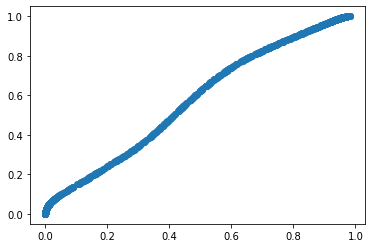

  93: TIME: 3.21 ETA: 22.46 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.93792411 0.97064827]]

0.28516319801149903 0.7100494785704908 [-0.07647183] [0.05122775]

[[0.49612807 0.98674495]]

0.2693534712590295 0.9108188390424 [-0.52154642] [0.2688768]

[[0.25988347 0.832571  ]]

0.2923475144593508 0.9822812805661255 [-0.7694666] [0.43895154]

[[0.24096156 0.73485129]]

0.32949500318202335 0.9730218867786232 [-0.80443673] [0.52614062]

[[0.24151606 0.68035666]]

0.3592166250060984 0.9703490914111482 [-0.80036424] [0.58413408]

[[0.24680904 0.6438907 ]]

0.38299590362507613 0.9740108093344267 [-0.78764643] [0.6282264]

[[0.25293915 0.61546575]]

0.403064969589571 0.9785545681216983 [-0.77358647] [0.66497555]

[[0.25879116 0.59137411]]

0.42046189659410754 0.9823943483816431 [-0.76013739] [0.69697782]

[[0.26415535 0.57034986]]

0.43572591597938776 0.9854114634428914 [-0.74768964] [0.72531388]

[[0.26903883 0.55183512]]

0.4492027892066838 0.9877589817713649 [-0.7362

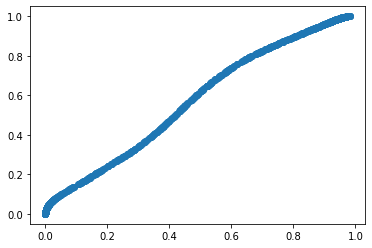

  94: TIME: 2.17 ETA: 12.99 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.94368739 0.97418277]]

0.2843615617005648 0.7165713832595874 [-0.06357826] [0.06156223]

[[0.49339526 0.99215945]]

0.268991689020939 0.9134099723785334 [-0.51303408] [0.28124677]

[[0.2618196  0.83948459]]

0.2925950343598141 0.9828322356300966 [-0.75680538] [0.44983089]

[[0.24424978 0.74444255]]

0.32951106275016295 0.9746790808311978 [-0.79011695] [0.53568819]

[[0.24514335 0.69088536]]

0.35933549796181596 0.9724546399607741 [-0.78570764] [0.59355602]

[[0.25037664 0.65420088]]

0.38339270453956015 0.975893968373374 [-0.77315116] [0.63816889]

[[0.25635117 0.62519979]]

0.4037565292661535 0.9801087688222447 [-0.75931956] [0.67560328]

[[0.26205426 0.60047106]]

0.4214329816070153 0.9836739719288357 [-0.74604149] [0.70830578]

[[0.26729613 0.5788172 ]]

0.43696224265174477 0.9864775404956138 [-0.73369654] [0.73732931]

[[0.27208495 0.55969555]]

0.4506935829612914 0.9886581741090923 [-0.

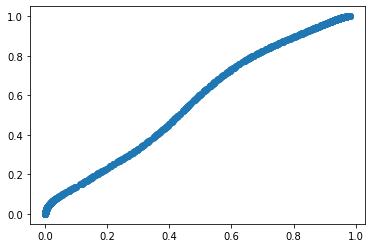

  95: TIME: 3.76 ETA: 18.82 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[0.96985239 0.98580804]]

0.286905716464931 0.7155107619985405 [-0.05894272] [0.06130459]

[[0.5173503  1.00968577]]

0.27118865711135925 0.9094063530453385 [-0.50464347] [0.28064234]

[[0.27040175 0.85557086]]

0.2923094437549054 0.9833741876069534 [-0.75901585] [0.45229763]

[[0.25093203 0.75767345]]

0.3283772429967695 0.9756488714296544 [-0.79540398] [0.5387188]

[[0.25136272 0.70316223]]

0.3578508805026537 0.9729733967899656 [-0.79178633] [0.59658937]

[[0.25647347 0.66617668]]

0.38161811166143556 0.9761361994605678 [-0.77951664] [0.64098104]

[[0.26245151 0.63718178]]

0.40171760705030135 0.9802495048209219 [-0.76579073] [0.67809205]

[[0.26818789 0.61256559]]

0.419155476684686 0.9837735381223385 [-0.75257343] [0.71044869]

[[0.27345971 0.59105179]]

0.4344682265399862 0.9865516755719177 [-0.74028885] [0.73913243]

[[0.27826781 0.57207397]]

0.44800176542447356 0.9887117570144377 [-0.7

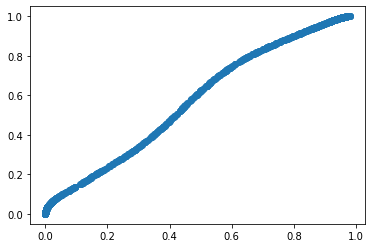

  96: TIME: 3.72 ETA: 14.87 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.01286504 1.04244813]]

0.2867993362881574 0.7036266722717033 [-0.06130683] [0.05449864]

[[0.55940549 1.06224367]]

0.2706965784086454 0.901649337446865 [-0.51572005] [0.27693147]

[[0.28550078 0.899672  ]]

0.29031447855157855 0.9825828970333911 [-0.78710437] [0.45603331]

[[0.26268957 0.79214068]]

0.32683878522333437 0.9740162023371176 [-0.82770124] [0.54713467]

[[0.26260918 0.73252357]]

0.3566163160283753 0.9707290571925501 [-0.82459796] [0.60759995]

[[0.26805668 0.69289976]]

0.38046420642953815 0.974088560069793 [-0.81175632] [0.65340953]

[[0.27459608 0.66228748]]

0.40058543184397777 0.9785852995188188 [-0.79721347] [0.69146248]

[[0.2808984  0.63646353]]

0.4180329985443305 0.9824468570788424 [-0.78320782] [0.72455669]

[[0.28668879 0.61396852]]

0.43334761237351654 0.9854903448782212 [-0.77022021] [0.75385004]

[[0.29196102 0.59417466]]

0.4468731572637733 0.9878562352453252 [-0

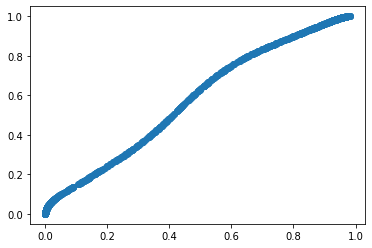

  97: TIME: 1.84 ETA: 5.51 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.00920704 1.06400019]]

0.2848972132197575 0.7139353254348157 [-0.08923925] [0.04460069]

[[0.54738963 1.07158893]]

0.2687070489419323 0.9128470294802595 [-0.554294] [0.27150521]

[[0.29268209 0.90677592]]

0.28872008575764996 0.9831520063548438 [-0.8124968] [0.44299493]

[[0.27044534 0.80192228]]

0.3242018172984107 0.9744269127149124 [-0.8514826] [0.5312816]

[[0.27002397 0.74279822]]

0.35321155095249024 0.9708510533112551 [-0.84888744] [0.59046334]

[[0.27526448 0.70364854]]

0.3763951436949965 0.973960865949414 [-0.8365297] [0.63511609]

[[0.28174133 0.67380256]]

0.39589259951256084 0.9783955852216496 [-0.82230622] [0.67193709]

[[0.28802394 0.6488796 ]]

0.4127522831056802 0.9822642720725753 [-0.80857431] [0.70377606]

[[0.29378394 0.62730841]]

0.4275085356698558 0.9853202132685623 [-0.79587895] [0.73182772]

[[0.29900064 0.60842111]]

0.44049971839451174 0.9876901280469542 [-0.784284

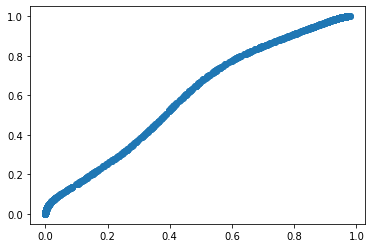

  98: TIME: 1.50 ETA: 3.00 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.08635987 1.10752591]]

0.28734477800272507 0.7184005859105511 [-0.10762383] [0.01800042]

[[0.60543472 1.12589877]]

0.27070913634642296 0.9086426487759783 [-0.57513992] [0.24732781]

[[0.31355693 0.95273357]]

0.28703496138269713 0.9835431213210485 [-0.85721594] [0.42686172]

[[0.28501608 0.83570761]]

0.32202670746298917 0.9736250601598785 [-0.90408328] [0.51988731]

[[0.28289434 0.77048526]]

0.3507871431956677 0.9682787559319826 [-0.9035824] [0.58115254]

[[0.28799603 0.72906629]]

0.37338344810348356 0.9711035833008057 [-0.89145435] [0.62604926]

[[0.29489059 0.69870624]]

0.39219644663151376 0.9758977750079502 [-0.87687292] [0.66232266]

[[0.301678   0.67387835]]

0.40837956788861773 0.9801886450700533 [-0.86274766] [0.69334756]

[[0.30788578 0.65262783]]

0.4224791146859914 0.9835879997827147 [-0.84977405] [0.72047652]

[[0.31346588 0.63417732]]

0.4348280575239493 0.9862187646421029 [

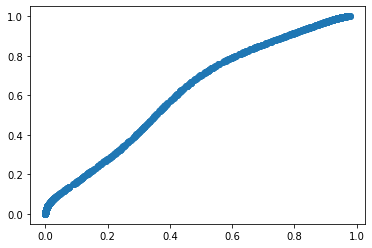

  99: TIME: 3.06 ETA: 3.06 AE_LOSS: 0.0000 DC_LOSS: 0.0000 DC_ACC: 0.0000 GEN_LOSS: 0.0000
[[1.14049674 1.16411188]]

0.2877444282576619 0.713277570864527 [-0.14896851] [0.00019131]

[[0.63742972 1.17828389]]

0.2702812603854722 0.9101315270173514 [-0.62162661] [0.23181295]

[[0.33283175 0.99385317]]

0.28521753388989907 0.9832803494069371 [-0.91065637] [0.41304723]

[[0.29973977 0.86724151]]

0.3199875927497128 0.9715701441776506 [-0.96154362] [0.50926454]

[[0.29596045 0.79616197]]

0.3483838195218263 0.9644852788219087 [-0.96266883] [0.57218566]

[[0.30093136 0.75275565]]

0.3702019920755264 0.9671488499976848 [-0.95070102] [0.61690107]

[[0.30830748 0.72227493]]

0.3881367533881231 0.9724801917082214 [-0.93574567] [0.65219341]

[[0.31566784 0.69792124]]

0.4034736952189912 0.9773536003643696 [-0.92123657] [0.68201335]

[[0.32237266 0.67732473]]

0.41676956051976294 0.9812165570188982 [-0.90801974] [0.70787296]

[[0.32834421 0.65960556]]

0.428345125187405 0.9841945198456394 [-0.896

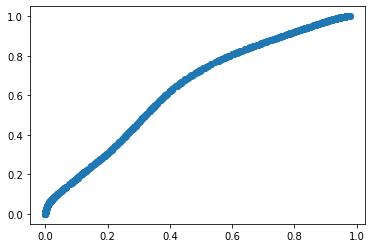

In [ ]:
aae.fit(xUnlabeledTrain,xPosTrain,validation_data=(xUnlabeledVal,xPosVal),batch_size=512)